## Prepare Data

In [3]:
import pandas as pd
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split

data = pd.read_csv('processed_data.csv')

# Selected features based on Feature Significance
selected_features = ['TX_AMOUNT', 'CONNECTED_ACCOUNTS', 'median', 'DEGREE_CENTRALITY', 'BETWEENNESS_CENTRALITY', 'LOC']
X = data[selected_features].values
y = data['IS_FRAUD'].values
edge_index = data[['SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID']].values.T

# Split data into training and test sets
X_train, X_test, y_train, y_test, edge_index_train, edge_index_test = train_test_split(X, y, edge_index.T, test_size=0.3, random_state=42)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float).unsqueeze(1)  # Ensure y_train has shape (N, 1)
edge_index_train = torch.tensor(edge_index_train.T, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float).unsqueeze(1)  # Ensure y_test has shape (N, 1)
edge_index_test = torch.tensor(edge_index_test.T, dtype=torch.long)

# Create the data objects for training and testing
data_train = Data(x=X_train, edge_index=edge_index_train, y=y_train)
data_test = Data(x=X_test, edge_index=edge_index_test, y=y_test)

# Verify shapes
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of edge_index_train: {edge_index_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of edge_index_test: {edge_index_test.shape}")
print(f"Shape of data_train.x: {data_train.x.shape}")
print(f"Shape of data_train.y: {data_train.y.shape}")
print(f"Shape of data_train.edge_index: {data_train.edge_index.shape}")

Shape of X_train: torch.Size([181345, 6])
Shape of y_train: torch.Size([181345, 1])
Shape of edge_index_train: torch.Size([2, 181345])
Shape of X_test: torch.Size([77720, 6])
Shape of y_test: torch.Size([77720, 1])
Shape of edge_index_test: torch.Size([2, 77720])
Shape of data_train.x: torch.Size([181345, 6])
Shape of data_train.y: torch.Size([181345, 1])
Shape of data_train.edge_index: torch.Size([2, 181345])


## Define GNN Model

The use of **ReLU activation** and dropout is used to add non-linearity and preventing overfitting, respectively.
The output layer produces a single value per node, suitable for binary classification. A **sigmoid function** and **threshold** will be applied to the output to obtain binary predictions.

In [4]:
import torch
from torch_geometric.nn import GCNConv

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, num_classes)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        print(f'Input x shape: {x.shape}')
        print(f'Input edge_index shape: {edge_index.shape}')
        
        x = self.conv1(x, edge_index)
        print(f'After conv1 x shape: {x.shape}')
        
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x, edge_index)
        print(f'After conv2 x shape: {x.shape}')
        
        x = self.relu(x)
        x = self.fc(x)
        print(f'After fc x shape: {x.shape}')
        
        return x

# Initialize the model
num_features = X_train.shape[1]
hidden_dim = 16
num_classes = 1  # Binary classification
model = GNNModel(num_features, hidden_dim, num_classes)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data_train = data_train.to(device)
data_test = data_test.to(device)

# Verify model structure
print(model)

GNNModel(
  (conv1): GCNConv(6, 16)
  (conv2): GCNConv(16, 16)
  (fc): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


**Architecture:**
- Graph Convolutional Layers (GCNConv)
- Fully Connected Layer (Linear)
- ReLU Activation (ReLU)
- Dropout Layer (Dropout)

**Components:**

- conv1: GCNConv(6, 16)

Type: Graph Convolutional Layer
Input Features: 6 (the number of input features for each node)
Output Features: 16 (the number of output features produced by this layer)
Function: This layer performs convolution operations on the graph, similar to how convolutional layers work on images. It aggregates information from neighboring nodes to produce a new set of features for each node.

- conv2: GCNConv(16, 16)

Type: Graph Convolutional Layer
Input Features: 16 (the output features from the previous layer)
Output Features: 16 (the number of output features produced by this layer)
Function: This layer further processes the node features generated by the first GCNConv layer, allowing the model to learn more complex patterns and relationships within the graph.

- fc: Linear(in_features=16, out_features=1, bias=True)

Type: Fully Connected Layer (also known as Dense or Linear Layer)
Input Features: 16 (the output features from the last GCN layer)
Output Features: 1 (the final output of the model, suitable for binary classification)
Function: This layer takes the node features produced by the GCN layers and maps them to a single output value, which is used to make the final prediction.

- relu: ReLU()

Type: Activation Function
Function: Applies the Rectified Linear Unit (ReLU) activation function to the output of the previous layer. ReLU introduces non-linearity into the model, allowing it to learn more complex patterns. The ReLU function outputs zero for negative inputs and the input itself for positive inputs.

- dropout: Dropout(p=0.5, inplace=False)

Type: Regularization Technique
Function: Dropout randomly sets a fraction p (0.5 in this case) of the input units to zero at each update during training time. This helps prevent overfitting by ensuring that the model does not rely too heavily on any single node or feature.

**Model Flow:**

- Input Layer: The model takes in graph data with node features of size 6.
- First GCN Layer: The first GCN layer processes the input features and produces 16 output features per node.
- ReLU Activation: The output of the first GCN layer passes through a ReLU activation function.
- Dropout: Dropout is applied to the activated features to prevent overfitting.
- Second GCN Layer: The second GCN layer takes the 16 features from the first GCN layer and produces another set of 16 features per node.
- ReLU Activation: The output of the second GCN layer passes through another ReLU activation function.
- Fully Connected Layer: The processed features are passed through a fully connected layer to produce a single output value per node.
- Output Layer: The final output is used for binary classification (e.g., predicting if a node is fraudulent or not).

## Train Model

**Model Definition:**

The model has two GCN layers followed by ReLU activation and dropout for regularization.
A fully connected (linear) layer at the end maps the features to the output.

**Training Loop:**

The model is trained for 100 epochs, with optimizer steps and loss computation at each epoch.
Every 10 epochs, the model prints the current loss and accuracy for monitoring.

In [5]:
import torch
from torch_geometric.nn import GCNConv

# Define the model architecture
class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, num_classes)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        print(f'Input x shape: {x.shape}')
        print(f'Input edge_index shape: {edge_index.shape}')
        
        x = self.conv1(x, edge_index)
        print(f'After conv1 x shape: {x.shape}')
        
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x, edge_index)
        print(f'After conv2 x shape: {x.shape}')
        
        x = self.relu(x)
        x = self.fc(x)
        print(f'After fc x shape: {x.shape}')
        
        return x

# Initialize the model
num_features = X_train.shape[1]
hidden_dim = 16
num_classes = 1  # Binary classification
model = GNNModel(num_features, hidden_dim, num_classes)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data_train = data_train.to(device)
data_test = data_test.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

# Training the model
model.train()
for epoch in range(100):  # Increase number of epochs for better training
    optimizer.zero_grad()
    out = model(data_train)
    
    # Debug: Print shapes of out and data_train.y
    if epoch % 10 == 0:  # Print every 10 epochs for now
        print(f'Epoch {epoch+1}:')
        print(f'Output shape: {out.shape}')  # This should match the target shape
        print(f'Target shape: {data_train.y.view(-1).shape}')
    
    out = out.view(-1)  # Flatten the output to match the shape of y_train
    
    loss = criterion(out, data_train.y.view(-1))  # Ensure target is also flattened
    
    loss.backward()
    optimizer.step()
    
    # Print training progress
    if (epoch + 1) % 10 == 0:  # Print every 10 epochs for now
        with torch.no_grad():
            preds_train = torch.sigmoid(out).round()
            correct_train = preds_train.eq(data_train.y.view(-1)).sum().item()
            accuracy_train = correct_train / len(data_train.y)
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {accuracy_train:.4f}')

Input x shape: torch.Size([181345, 6])
Input edge_index shape: torch.Size([2, 181345])
After conv1 x shape: torch.Size([181345, 16])
After conv2 x shape: torch.Size([181345, 16])
After fc x shape: torch.Size([181345, 1])
Epoch 1:
Output shape: torch.Size([181345, 1])
Target shape: torch.Size([181345])
Input x shape: torch.Size([181345, 6])
Input edge_index shape: torch.Size([2, 181345])
After conv1 x shape: torch.Size([181345, 16])
After conv2 x shape: torch.Size([181345, 16])
After fc x shape: torch.Size([181345, 1])
Input x shape: torch.Size([181345, 6])
Input edge_index shape: torch.Size([2, 181345])
After conv1 x shape: torch.Size([181345, 16])
After conv2 x shape: torch.Size([181345, 16])
After fc x shape: torch.Size([181345, 1])
Input x shape: torch.Size([181345, 6])
Input edge_index shape: torch.Size([2, 181345])
After conv1 x shape: torch.Size([181345, 16])
After conv2 x shape: torch.Size([181345, 16])
After fc x shape: torch.Size([181345, 1])
Input x shape: torch.Size([181345,

Input x shape: torch.Size([181345, 6])
Input edge_index shape: torch.Size([2, 181345])
After conv1 x shape: torch.Size([181345, 16])
After conv2 x shape: torch.Size([181345, 16])
After fc x shape: torch.Size([181345, 1])
Input x shape: torch.Size([181345, 6])
Input edge_index shape: torch.Size([2, 181345])
After conv1 x shape: torch.Size([181345, 16])
After conv2 x shape: torch.Size([181345, 16])
After fc x shape: torch.Size([181345, 1])
Input x shape: torch.Size([181345, 6])
Input edge_index shape: torch.Size([2, 181345])
After conv1 x shape: torch.Size([181345, 16])
After conv2 x shape: torch.Size([181345, 16])
After fc x shape: torch.Size([181345, 1])
Input x shape: torch.Size([181345, 6])
Input edge_index shape: torch.Size([2, 181345])
After conv1 x shape: torch.Size([181345, 16])
After conv2 x shape: torch.Size([181345, 16])
After fc x shape: torch.Size([181345, 1])
Epoch 40, Loss: 0.0131, Accuracy: 0.9992
Input x shape: torch.Size([181345, 6])
Input edge_index shape: torch.Size([

Input x shape: torch.Size([181345, 6])
Input edge_index shape: torch.Size([2, 181345])
After conv1 x shape: torch.Size([181345, 16])
After conv2 x shape: torch.Size([181345, 16])
After fc x shape: torch.Size([181345, 1])
Input x shape: torch.Size([181345, 6])
Input edge_index shape: torch.Size([2, 181345])
After conv1 x shape: torch.Size([181345, 16])
After conv2 x shape: torch.Size([181345, 16])
After fc x shape: torch.Size([181345, 1])
Input x shape: torch.Size([181345, 6])
Input edge_index shape: torch.Size([2, 181345])
After conv1 x shape: torch.Size([181345, 16])
After conv2 x shape: torch.Size([181345, 16])
After fc x shape: torch.Size([181345, 1])
Input x shape: torch.Size([181345, 6])
Input edge_index shape: torch.Size([2, 181345])
After conv1 x shape: torch.Size([181345, 16])
After conv2 x shape: torch.Size([181345, 16])
After fc x shape: torch.Size([181345, 1])
Input x shape: torch.Size([181345, 6])
Input edge_index shape: torch.Size([2, 181345])
After conv1 x shape: torch.Si

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

model.eval()
with torch.no_grad():
    out_test = model(data_test)
    out_test = out_test.view(-1)  # Flatten the output to match the shape of y_test
    preds_test = torch.sigmoid(out_test).round().cpu().numpy()
    y_test = data_test.y.view(-1).cpu().numpy()
    
    # Compute metrics
    accuracy_test = (preds_test == y_test).mean()
    precision_test = precision_score(y_test, preds_test)
    recall_test = recall_score(y_test, preds_test)
    f1_test = f1_score(y_test, preds_test)
    roc_auc_test = roc_auc_score(y_test, torch.sigmoid(out_test).cpu().numpy())
    
    print(f'Test Accuracy: {accuracy_test:.4f}')
    print(f'Test Precision: {precision_test:.4f}')
    print(f'Test Recall: {recall_test:.4f}')
    print(f'Test F1 Score: {f1_test:.4f}')
    print(f'Test ROC AUC: {roc_auc_test:.4f}')

Input x shape: torch.Size([77720, 6])
Input edge_index shape: torch.Size([2, 60654])
After conv1 x shape: torch.Size([77720, 16])
After conv2 x shape: torch.Size([77720, 16])
After fc x shape: torch.Size([77720, 1])
Test Accuracy: 0.9990
Test Precision: 0.0000
Test Recall: 0.0000
Test F1 Score: 0.0000
Test ROC AUC: 0.5618


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Given the poor performance metrics despite the high accuracy, it indicates that the model is likely predicting the majority class (non-fraudulent transactions) overwhelmingly, which is common in highly imbalanced datasets.

**Next Steps:**
- Data Balancing Techniques: Ensure proper resampling techniques like SMOTE, ADASYN, or undersampling are used correctly to balance the dataset.
- Tune the Model: Adjust hyperparameters such as learning rate, number of layers, and hidden units.
- Implement different architectures like Graph Attention Networks (GAT) or GraphSAGE.
- Add Regularization: Apply techniques like L2 regularization or dropout to prevent overfitting.
- Cost-Sensitive Learning: Implement a cost-sensitive learning approach where the model gives higher penalties to misclassifying minority class instances (fraudulent transactions).
- Class Weights:Incorporate class weights in loss function to handle the imbalance.
- Ensemble Methods: like Random Forest, Gradient Boosting, or XGBoost with tuned hyperparameters. Ensemble methods often provide more robust performance.

## Adjusted model Training and Evaluation 1

In [13]:
import torch
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import numpy as np

# Data balancing using SMOTE and RandomUnderSampler
def balance_data(X_train, y_train):
    smote = SMOTE(sampling_strategy=0.1, random_state=42)
    X_smote, y_smote = smote.fit_resample(X_train, y_train)
    
    undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
    X_resampled, y_resampled = undersample.fit_resample(X_smote, y_smote)
    
    return X_resampled, y_resampled

# Assume X_train and y_train are your training data
X_train_resampled, y_train_resampled = balance_data(X_train, y_train)

# Convert the resampled data back to PyTorch tensors
X_train_resampled_tensor = torch.tensor(X_train_resampled, dtype=torch.float)
y_train_resampled_tensor = torch.tensor(y_train_resampled, dtype=torch.float).view(-1, 1)

# Adjust edge indices to ensure they are within bounds after resampling
max_index = X_train_resampled_tensor.size(0) - 1
edge_index_train = edge_index_train[:, (edge_index_train[0] <= max_index) & (edge_index_train[1] <= max_index)]

# Create data object for the balanced training set
from torch_geometric.data import Data
data_train_resampled = Data(x=X_train_resampled_tensor, edge_index=edge_index_train, y=y_train_resampled_tensor)

# Define the GNN model
class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, num_classes)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        print(f'Input x shape: {x.shape}')
        print(f'Input edge_index shape: {edge_index.shape}')
        
        x = self.conv1(x, edge_index)
        print(f'After conv1 x shape: {x.shape}')
        
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x, edge_index)
        print(f'After conv2 x shape: {x.shape}')
        
        x = self.relu(x)
        x = self.fc(x)
        print(f'After fc x shape: {x.shape}')
        
        return x

# Initialize the model
num_features = X_train_resampled.shape[1]
hidden_dim = 16
num_classes = 1  # Binary classification
model = GNNModel(num_features, hidden_dim, num_classes)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data_train_resampled = data_train_resampled.to(device)
data_test = data_test.to(device)

# Calculate class weights to handle class imbalance
class_counts = np.bincount(y_train_resampled.astype(int))
class_weights = torch.tensor([1.0 / class_counts[0], 1.0 / class_counts[1]], dtype=torch.float).to(device)

# Define optimizer and loss function with class weights
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights[1])  # Adjust class weights

# Training the model
model.train()
for epoch in range(100):  # Increase number of epochs for better training
    optimizer.zero_grad()
    out = model(data_train_resampled)
    
    # Debug: Print shapes of out and data_train_resampled.y
    if epoch % 10 == 0:  # Print every 10 epochs for now
        print(f'Epoch {epoch+1}:')
        print(f'Output shape: {out.shape}')  # This should match the target shape
        print(f'Target shape: {data_train_resampled.y.view(-1).shape}')
    
    out = out.view(-1)  # Flatten the output to match the shape of y_train
    
    loss = criterion(out, data_train_resampled.y.view(-1))  # Ensure target is also flattened
    
    loss.backward()
    optimizer.step()
    
    # Print training progress
    if (epoch + 1) % 10 == 0:  # Print every 10 epochs for now
        with torch.no_grad():
            preds_train = torch.sigmoid(out).round()
            correct_train = preds_train.eq(data_train_resampled.y.view(-1)).sum().item()
            accuracy_train = correct_train / len(data_train_resampled.y)
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {accuracy_train:.4f}')

Input x shape: torch.Size([54357, 6])
Input edge_index shape: torch.Size([2, 97632])
After conv1 x shape: torch.Size([54357, 16])
After conv2 x shape: torch.Size([54357, 16])
After fc x shape: torch.Size([54357, 1])
Epoch 1:
Output shape: torch.Size([54357, 1])
Target shape: torch.Size([54357])
Input x shape: torch.Size([54357, 6])
Input edge_index shape: torch.Size([2, 97632])
After conv1 x shape: torch.Size([54357, 16])
After conv2 x shape: torch.Size([54357, 16])
After fc x shape: torch.Size([54357, 1])
Input x shape: torch.Size([54357, 6])
Input edge_index shape: torch.Size([2, 97632])
After conv1 x shape: torch.Size([54357, 16])
After conv2 x shape: torch.Size([54357, 16])
After fc x shape: torch.Size([54357, 1])
Input x shape: torch.Size([54357, 6])
Input edge_index shape: torch.Size([2, 97632])
After conv1 x shape: torch.Size([54357, 16])
After conv2 x shape: torch.Size([54357, 16])
After fc x shape: torch.Size([54357, 1])
Input x shape: torch.Size([54357, 6])
Input edge_index s

After conv2 x shape: torch.Size([54357, 16])
After fc x shape: torch.Size([54357, 1])
Input x shape: torch.Size([54357, 6])
Input edge_index shape: torch.Size([2, 97632])
After conv1 x shape: torch.Size([54357, 16])
After conv2 x shape: torch.Size([54357, 16])
After fc x shape: torch.Size([54357, 1])
Input x shape: torch.Size([54357, 6])
Input edge_index shape: torch.Size([2, 97632])
After conv1 x shape: torch.Size([54357, 16])
After conv2 x shape: torch.Size([54357, 16])
After fc x shape: torch.Size([54357, 1])
Epoch 40, Loss: 0.0075, Accuracy: 0.6667
Input x shape: torch.Size([54357, 6])
Input edge_index shape: torch.Size([2, 97632])
After conv1 x shape: torch.Size([54357, 16])
After conv2 x shape: torch.Size([54357, 16])
After fc x shape: torch.Size([54357, 1])
Epoch 41:
Output shape: torch.Size([54357, 1])
Target shape: torch.Size([54357])
Input x shape: torch.Size([54357, 6])
Input edge_index shape: torch.Size([2, 97632])
After conv1 x shape: torch.Size([54357, 16])
After conv2 x 

Input x shape: torch.Size([54357, 6])
Input edge_index shape: torch.Size([2, 97632])
After conv1 x shape: torch.Size([54357, 16])
After conv2 x shape: torch.Size([54357, 16])
After fc x shape: torch.Size([54357, 1])
Input x shape: torch.Size([54357, 6])
Input edge_index shape: torch.Size([2, 97632])
After conv1 x shape: torch.Size([54357, 16])
After conv2 x shape: torch.Size([54357, 16])
After fc x shape: torch.Size([54357, 1])
Input x shape: torch.Size([54357, 6])
Input edge_index shape: torch.Size([2, 97632])
After conv1 x shape: torch.Size([54357, 16])
After conv2 x shape: torch.Size([54357, 16])
After fc x shape: torch.Size([54357, 1])
Input x shape: torch.Size([54357, 6])
Input edge_index shape: torch.Size([2, 97632])
After conv1 x shape: torch.Size([54357, 16])
After conv2 x shape: torch.Size([54357, 16])
After fc x shape: torch.Size([54357, 1])
Input x shape: torch.Size([54357, 6])
Input edge_index shape: torch.Size([2, 97632])
After conv1 x shape: torch.Size([54357, 16])
After 

In [14]:
# Evaluation on the test set
model.eval()
with torch.no_grad():
    out_test = model(data_test)
    out_test = out_test.view(-1)  # Flatten the output to match the shape of y_test
    preds_test = torch.sigmoid(out_test).round()
    
    # Calculate evaluation metrics
    accuracy_test = accuracy_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    precision_test = precision_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy(), zero_division=1)
    recall_test = recall_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy(), zero_division=1)
    f1_test = f1_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy(), zero_division=1)
    roc_auc_test = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())
    
    print(f'Test Accuracy: {accuracy_test:.4f}')
    print(f'Test Precision: {precision_test:.4f}')
    print(f'Test Recall: {recall_test:.4f}')
    print(f'Test F1 Score: {f1_test:.4f}')
    print(f'Test ROC AUC: {roc_auc_test:.4f}')

Input x shape: torch.Size([77720, 6])
Input edge_index shape: torch.Size([2, 60654])
After conv1 x shape: torch.Size([77720, 16])
After conv2 x shape: torch.Size([77720, 16])
After fc x shape: torch.Size([77720, 1])
Test Accuracy: 0.9990
Test Precision: 1.0000
Test Recall: 0.0000
Test F1 Score: 0.0000
Test ROC AUC: 0.4330


## Adjusted model Training and Evaluation 2

**Next Steps:**

Advanced Feature Engineering:

- Interaction Features: Create features that capture interactions between variables, such as the ratio between transaction amount and the initial balance.
- Temporal Features: Incorporate more granular temporal features, such as the hour of the day, day of the week, or month of the year when transactions occur.
- Behavioral Patterns: Extract features that capture behavioral patterns over time, such as moving averages or the number of transactions within the last 24 hours.
- Graph-Based Features: Use more sophisticated graph features like PageRank, eigenvector centrality, or community detection metrics.

Modeling Techniques:

- Ensemble Methods: ensemble methods like Random Forests or Gradient Boosting Machines can handle feature importance better and may perform better on imbalanced datasets.
- Hybrid Models: Combine GNNs with traditional machine learning models to leverage both graph-based and non-graph-based features.
- Anomaly Detection: Implement unsupervised anomaly detection techniques to detect outliers which may be potential frauds.

Sampling Techniques:

- Oversampling/Undersampling: Experiment with different ratios of oversampling the minority class or undersampling the majority class.
- Synthetic Data Generation: Generate synthetic samples using techniques like SMOTE or ADASYN for better class balance.

In [19]:

# Interaction Features: ratio between transaction amount and initial balance
data['AMOUNT_BALANCE_RATIO'] = data['TX_AMOUNT'] / (data['INIT_BALANCE'] + 1e-9)

# Temporal Features: Extracting hour, day of the week, and month
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'], unit='s')
data['HOUR'] = data['TIMESTAMP'].dt.hour
data['DAY_OF_WEEK'] = data['TIMESTAMP'].dt.dayofweek
data['MONTH'] = data['TIMESTAMP'].dt.month

# Behavioral Patterns: Moving averages and counts
def calculate_behavioral_patterns(df, window_size=24):
    df['TX_AMOUNT_MA'] = df['TX_AMOUNT'].rolling(window=window_size, min_periods=1).mean()
    df['TX_COUNT_LAST_24H'] = df['TX_AMOUNT'].rolling(window=window_size, min_periods=1).count()
    return df

data = data.sort_values(by='TIMESTAMP')
data = calculate_behavioral_patterns(data)

# Graph-Based Features: PageRank, Eigenvector Centrality, Community Detection
# Generate edge_list from sender and receiver account IDs
edge_list = list(zip(data['SENDER_ACCOUNT_ID'], data['RECEIVER_ACCOUNT_ID']))

# Create NetworkX graph
G = nx.from_edgelist(edge_list)

# PageRank
pagerank_dict = nx.pagerank(G)
data['PAGERANK'] = data['SENDER_ACCOUNT_ID'].map(pagerank_dict).fillna(0)

# Eigenvector Centrality with increased max iterations
try:
    eigenvector_dict = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)
except nx.PowerIterationFailedConvergence:
    print("Power iteration failed to converge for Eigenvector Centrality")
    eigenvector_dict = {node: 0 for node in G.nodes()}  # Default to zero if convergence fails

data['EIGENVECTOR_CENTRALITY'] = data['SENDER_ACCOUNT_ID'].map(eigenvector_dict).fillna(0)

# Community Detection
import community as community_louvain
partition = community_louvain.best_partition(G)
data['COMMUNITY'] = data['SENDER_ACCOUNT_ID'].map(partition).fillna(-1)

In [20]:
data

,SENDER_ACCOUNT_ID,RECEIVER_ACCOUNT_ID,INIT_BALANCE,TX_BEHAVIOR_ID,TX_AMOUNT,TIMESTAMP,IS_FRAUD,ALERT_ID,ALERT_TYPE_cycle,ALERT_TYPE_fan_in,...,COMMUNITY,BETWEENNESS_CENTRALITY,AMOUNT_BALANCE_RATIO,HOUR,DAY_OF_WEEK,MONTH,TX_AMOUNT_MA,TX_COUNT_LAST_24H,PAGERANK,EIGENVECTOR_CENTRALITY
120205,841.0,50051.0,1.355927,0.0,-0.337909,1969-12-31 23:59:58.281968956,0.0,-1.0,0.0,0.0,...,0,-0.126303,-0.249209,23,2,12,-0.337909,1.0,0.000469,4.954771e-08
155725,944.0,57479.0,-0.369201,0.0,-0.976795,1969-12-31 23:59:58.281968956,0.0,-1.0,0.0,0.0,...,205,0.366300,2.645702,23,2,12,-0.657352,2.0,0.000818,5.650899e-07
221634,1253.0,29265.0,1.019184,0.0,0.975798,1969-12-31 23:59:58.281968956,0.0,-1.0,0.0,0.0,...,2,-0.522007,0.957431,23,2,12,-0.112969,3.0,0.000249,5.703578e-120
221633,1253.0,90732.0,1.019184,0.0,0.975798,1969-12-31 23:59:58.281968956,0.0,-1.0,0.0,0.0,...,2,-0.522007,0.957431,23,2,12,0.159223,4.0,0.000249,5.703578e-120
221632,1253.0,23491.0,1.019184,0.0,0.975798,1969-12-31 23:59:58.281968956,0.0,-1.0,0.0,0.0,...,2,-0.522007,0.957431,23,2,12,0.322538,5.0,0.000249,5.703578e-120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27256,299.0,6829.0,0.792426,0.0,0.557329,1970-01-01 00:00:01.735036994,0.0,-1.0,0.0,0.0,...,125,-0.469943,0.703320,0,3,1,-0.374446,24.0,0.000261,2.339814e-09
27255,299.0,36236.0,0.792426,0.0,0.557329,1970-01-01 00:00:01.735036994,0.0,-1.0,0.0,0.0,...,125,-0.469943,0.703320,0,3,1,-0.384961,24.0,0.000261,2.339814e-09
27254,299.0,29224.0,0.792426,0.0,0.557329,1970-01-01 00:00:01.735036994,0.0,-1.0,0.0,0.0,...,125,-0.469943,0.703320,0,3,1,-0.320274,24.0,0.000261,2.339814e-09
66105,578.0,46031.0,-1.217846,0.0,-0.408187,1970-01-01 00:00:01.735036994,0.0,-1.0,0.0,0.0,...,1,-0.521989,0.335171,0,3,1,-0.295816,24.0,0.000353,3.518261e-105


In [24]:
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import networkx as nx

# Selected features
selected_features = [
    'TX_AMOUNT', 'INIT_BALANCE', 'AMOUNT_BALANCE_RATIO', 
    'HOUR', 'DAY_OF_WEEK', 'MONTH', 
    'TX_AMOUNT_MA', 'TX_COUNT_LAST_24H', 
    'PAGERANK', 'EIGENVECTOR_CENTRALITY', 'COMMUNITY'
]

# Prepare the dataset
X = data[selected_features].values
y = data['IS_FRAUD'].values

# Split the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.float).view(-1, 1)

# Create edge_index for the training and test set
edge_index_train = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
edge_index_test = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

# Creating PyTorch geometric Data objects
data_train = Data(x=X_train_tensor, edge_index=edge_index_train, y=y_train_tensor)
data_test = Data(x=X_test_tensor, edge_index=edge_index_test, y=y_test_tensor)

# Verify the data shapes
print(f'Shape of data_train.x: {data_train.x.shape}')
print(f'Shape of data_train.y: {data_train.y.shape}')
print(f'Shape of data_train.edge_index: {data_train.edge_index.shape}')
print(f'Shape of data_test.x: {data_test.x.shape}')
print(f'Shape of data_test.y: {data_test.y.shape}')
print(f'Shape of data_test.edge_index: {data_test.edge_index.shape}')

Shape of data_train.x: torch.Size([207252, 11])
Shape of data_train.y: torch.Size([207252, 1])
Shape of data_train.edge_index: torch.Size([2, 259065])
Shape of data_test.x: torch.Size([51813, 11])
Shape of data_test.y: torch.Size([51813, 1])
Shape of data_test.edge_index: torch.Size([2, 259065])


In [25]:
# Define the GNN model
class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, num_classes)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        print(f'Input x shape: {x.shape}')
        print(f'Input edge_index shape: {edge_index.shape}')
        
        x = self.conv1(x, edge_index)
        print(f'After conv1 x shape: {x.shape}')
        
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x, edge_index)
        print(f'After conv2 x shape: {x.shape}')
        
        x = self.relu(x)
        x = self.fc(x)
        print(f'After fc x shape: {x.shape}')
        
        return x

# Initialize the model
num_features = X_train.shape[1]
hidden_dim = 16
num_classes = 1  # Binary classification
model = GNNModel(num_features, hidden_dim, num_classes)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data_train = data_train.to(device)
data_test = data_test.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

# Training the model
model.train()
for epoch in range(100):  # Increase number of epochs for better training
    optimizer.zero_grad()
    out = model(data_train)
    
    # Debug: Print shapes of out and data_train.y
    if epoch % 10 == 0:  # Print every 10 epochs for now
        print(f'Epoch {epoch+1}:')
        print(f'Output shape: {out.shape}')  # This should match the target shape
        print(f'Target shape: {data_train.y.view(-1).shape}')
    
    out = out.view(-1)  # Flatten the output to match the shape of y_train
    
    loss = criterion(out, data_train.y.view(-1))  # Ensure target is also flattened
    
    loss.backward()
    optimizer.step()
    
    # Print training progress
    if (epoch + 1) % 10 == 0:  # Print every 10 epochs for now
        with torch.no_grad():
            preds_train = torch.sigmoid(out).round()
            correct_train = preds_train.eq(data_train.y.view(-1)).sum().item()
            accuracy_train = correct_train / len(data_train.y)
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {accuracy_train:.4f}')

Input x shape: torch.Size([207252, 11])
Input edge_index shape: torch.Size([2, 259065])
After conv1 x shape: torch.Size([207252, 16])
After conv2 x shape: torch.Size([207252, 16])
After fc x shape: torch.Size([207252, 1])
Epoch 1:
Output shape: torch.Size([207252, 1])
Target shape: torch.Size([207252])
Input x shape: torch.Size([207252, 11])
Input edge_index shape: torch.Size([2, 259065])
After conv1 x shape: torch.Size([207252, 16])
After conv2 x shape: torch.Size([207252, 16])
After fc x shape: torch.Size([207252, 1])
Input x shape: torch.Size([207252, 11])
Input edge_index shape: torch.Size([2, 259065])
After conv1 x shape: torch.Size([207252, 16])
After conv2 x shape: torch.Size([207252, 16])
After fc x shape: torch.Size([207252, 1])
Input x shape: torch.Size([207252, 11])
Input edge_index shape: torch.Size([2, 259065])
After conv1 x shape: torch.Size([207252, 16])
After conv2 x shape: torch.Size([207252, 16])
After fc x shape: torch.Size([207252, 1])
Input x shape: torch.Size([207

Input x shape: torch.Size([207252, 11])
Input edge_index shape: torch.Size([2, 259065])
After conv1 x shape: torch.Size([207252, 16])
After conv2 x shape: torch.Size([207252, 16])
After fc x shape: torch.Size([207252, 1])
Input x shape: torch.Size([207252, 11])
Input edge_index shape: torch.Size([2, 259065])
After conv1 x shape: torch.Size([207252, 16])
After conv2 x shape: torch.Size([207252, 16])
After fc x shape: torch.Size([207252, 1])
Input x shape: torch.Size([207252, 11])
Input edge_index shape: torch.Size([2, 259065])
After conv1 x shape: torch.Size([207252, 16])
After conv2 x shape: torch.Size([207252, 16])
After fc x shape: torch.Size([207252, 1])
Input x shape: torch.Size([207252, 11])
Input edge_index shape: torch.Size([2, 259065])
After conv1 x shape: torch.Size([207252, 16])
After conv2 x shape: torch.Size([207252, 16])
After fc x shape: torch.Size([207252, 1])
Input x shape: torch.Size([207252, 11])
Input edge_index shape: torch.Size([2, 259065])
After conv1 x shape: tor

Input x shape: torch.Size([207252, 11])
Input edge_index shape: torch.Size([2, 259065])
After conv1 x shape: torch.Size([207252, 16])
After conv2 x shape: torch.Size([207252, 16])
After fc x shape: torch.Size([207252, 1])
Input x shape: torch.Size([207252, 11])
Input edge_index shape: torch.Size([2, 259065])
After conv1 x shape: torch.Size([207252, 16])
After conv2 x shape: torch.Size([207252, 16])
After fc x shape: torch.Size([207252, 1])
Input x shape: torch.Size([207252, 11])
Input edge_index shape: torch.Size([2, 259065])
After conv1 x shape: torch.Size([207252, 16])
After conv2 x shape: torch.Size([207252, 16])
After fc x shape: torch.Size([207252, 1])
Input x shape: torch.Size([207252, 11])
Input edge_index shape: torch.Size([2, 259065])
After conv1 x shape: torch.Size([207252, 16])
After conv2 x shape: torch.Size([207252, 16])
After fc x shape: torch.Size([207252, 1])
Input x shape: torch.Size([207252, 11])
Input edge_index shape: torch.Size([2, 259065])
After conv1 x shape: tor

## Adjusted model Training and Evaluation 3

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
import torch
import torch_geometric
from torch_geometric.data import Data

smote_enn = SMOTEENN(sampling_strategy=0.8, random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# Splitting the resampled data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.float).view(-1, 1)

# Creating edge_index for the training and test set
def create_edge_index(num_nodes):
    row = torch.randint(0, num_nodes, (2, num_nodes))
    return row

edge_index_train = create_edge_index(X_train_tensor.size(0))
edge_index_test = create_edge_index(X_test_tensor.size(0))

# Creating PyTorch geometric Data objects
data_train = Data(x=X_train_tensor, edge_index=edge_index_train, y=y_train_tensor)
data_test = Data(x=X_test_tensor, edge_index=edge_index_test, y=y_test_tensor)

In [35]:
import torch
from torch_geometric.nn import GCNConv

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, num_classes)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.fc(x)
        return x

# Initialize the model
num_features = X_train.shape[1]
hidden_dim = 16
num_classes = 1  # Binary classification
model = GNNModel(num_features, hidden_dim, num_classes)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data_train = data_train.to(device)
data_test = data_test.to(device)

In [36]:
# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

# Training the model
model.train()
for epoch in range(100):  # Increase number of epochs for better training
    optimizer.zero_grad()
    out = model(data_train)
    
    out = out.view(-1)  # Flatten the output to match the shape of y_train
    
    loss = criterion(out, data_train.y.view(-1))  # Ensure target is also flattened
    
    loss.backward()
    optimizer.step()
    
    # Print training progress
    if (epoch + 1) % 10 == 0:  # Print every 10 epochs for now
        with torch.no_grad():
            preds_train = torch.sigmoid(out).round()
            correct_train = preds_train.eq(data_train.y.view(-1)).sum().item()
            accuracy_train = correct_train / len(data_train.y)
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {accuracy_train:.4f}')

Epoch 10, Loss: 0.6775, Accuracy: 0.5648
Epoch 20, Loss: 0.6610, Accuracy: 0.5900
Epoch 30, Loss: 0.6485, Accuracy: 0.6119
Epoch 40, Loss: 0.6396, Accuracy: 0.6224
Epoch 50, Loss: 0.6324, Accuracy: 0.6287
Epoch 60, Loss: 0.6271, Accuracy: 0.6403
Epoch 70, Loss: 0.6217, Accuracy: 0.6462
Epoch 80, Loss: 0.6181, Accuracy: 0.6486
Epoch 90, Loss: 0.6149, Accuracy: 0.6491
Epoch 100, Loss: 0.6122, Accuracy: 0.6537


In [37]:
data = pd.read_csv('processed_data.csv')

In [39]:
data

,SENDER_ACCOUNT_ID,RECEIVER_ACCOUNT_ID,INIT_BALANCE,TX_BEHAVIOR_ID,TX_AMOUNT,TIMESTAMP,IS_FRAUD,ALERT_ID,ALERT_TYPE_cycle,ALERT_TYPE_fan_in,...,LOC,IS_ATYPICAL,median,mad,CONNECTED_ACCOUNTS,CLUSTERING_COEFFICIENT,DEGREE_CENTRALITY,COMMUNITY,BETWEENNESS_CENTRALITY,TX_AMOUNT_INIT_BALANCE_RATIO
0,0.0,17405.0,1.164472,0.0,13.307883,-1.700679,0.0,-1.0,0.0,0.0,...,0.347485,False,0.068610,-0.00958,-0.966717,-0.1591,-0.966717,124,-0.513339,11.428253
1,0.0,17405.0,1.164472,0.0,13.307883,-1.197468,0.0,-1.0,0.0,0.0,...,0.347485,False,0.068610,-0.00958,-0.966717,-0.1591,-0.966717,124,-0.513339,11.428253
2,0.0,17405.0,1.164472,0.0,13.307883,-1.076003,0.0,-1.0,0.0,0.0,...,0.347485,False,0.068610,-0.00958,-0.966717,-0.1591,-0.966717,124,-0.513339,11.428253
3,0.0,17405.0,1.164472,0.0,13.307883,-0.902482,0.0,-1.0,0.0,0.0,...,0.347485,False,0.068610,-0.00958,-0.966717,-0.1591,-0.966717,124,-0.513339,11.428253
4,0.0,17405.0,1.164472,0.0,13.307883,-0.867778,0.0,-1.0,0.0,0.0,...,0.347485,False,0.068610,-0.00958,-0.966717,-0.1591,-0.966717,124,-0.513339,11.428253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259060,1532.0,44430.0,-1.564773,0.0,-0.383430,-1.579214,0.0,-1.0,0.0,0.0,...,0.010749,False,-0.014168,-0.00958,-0.484274,-0.1591,-0.484274,288,-0.461267,0.245039
259061,1532.0,13689.0,-1.564773,0.0,-0.383430,-1.509806,0.0,-1.0,0.0,0.0,...,0.007819,False,-0.014168,-0.00958,-0.484274,-0.1591,-0.484274,288,-0.461267,0.245039
259062,1532.0,31693.0,-1.564773,0.0,-0.383430,-1.509806,0.0,-1.0,0.0,0.0,...,0.004889,False,-0.014168,-0.00958,-0.484274,-0.1591,-0.484274,288,-0.461267,0.245039
259063,1532.0,90747.0,-1.564773,0.0,-0.383430,-1.509806,0.0,-1.0,0.0,0.0,...,0.001959,False,-0.014168,-0.00958,-0.484274,-0.1591,-0.484274,288,-0.461267,0.245039


In [40]:
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import networkx as nx

# Ensure TIMESTAMP is in datetime format
if not pd.api.types.is_datetime64_any_dtype(data['TIMESTAMP']):
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

# Creating interaction features and temporal features
data['TX_AMOUNT_INIT_BALANCE_RATIO'] = data['TX_AMOUNT'] / data['INIT_BALANCE']
data['HOUR'] = data['TIMESTAMP'].dt.hour
data['DAY_OF_WEEK'] = data['TIMESTAMP'].dt.dayofweek
data['MONTH'] = data['TIMESTAMP'].dt.month

# Behavioral patterns
data['TX_AMOUNT_MOVING_AVG'] = data['TX_AMOUNT'].rolling(window=24).mean()
data['TX_AMOUNT_MOVING_STD'] = data['TX_AMOUNT'].rolling(window=24).std()
data['NUM_TX_24H'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].rolling(window=24).count().reset_index(0, drop=True)

# Graph-based features
G = nx.from_pandas_edgelist(data, 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', ['TX_AMOUNT'])
pagerank_dict = nx.pagerank(G)
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=500)
data['PAGERANK'] = data['SENDER_ACCOUNT_ID'].map(pagerank_dict).fillna(0)
data['EIGENVECTOR_CENTRALITY'] = data['SENDER_ACCOUNT_ID'].map(eigenvector_dict).fillna(0)

# Prepare the dataset
selected_features = [
    'TX_AMOUNT', 'TX_AMOUNT_INIT_BALANCE_RATIO', 'HOUR', 'DAY_OF_WEEK', 
    'MONTH', 'TX_AMOUNT_MOVING_AVG', 'TX_AMOUNT_MOVING_STD', 
    'NUM_TX_24H', 'PAGERANK', 'EIGENVECTOR_CENTRALITY'
]
X = data[selected_features].fillna(0).values
y = data['IS_FRAUD'].values

# Resampling
smote_enn = SMOTEENN(sampling_strategy=0.8, random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# Splitting the resampled data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.float).view(-1, 1)

# Creating edge_index for the training and test set
def create_edge_index(num_nodes):
    row = torch.randint(0, num_nodes, (2, num_nodes))
    return row

edge_index_train = create_edge_index(X_train_tensor.size(0))
edge_index_test = create_edge_index(X_test_tensor.size(0))

# Creating PyTorch geometric Data objects
data_train = Data(x=X_train_tensor, edge_index=edge_index_train, y=y_train_tensor)
data_test = Data(x=X_test_tensor, edge_index=edge_index_test, y=y_test_tensor)

/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/pandas/core/window/rolling.py:1631: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  FutureWarning,


In [41]:
# Define the GNN model
class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, num_classes)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.fc(x)
        return x

# Initialize the model
num_features = X_train.shape[1]
hidden_dim = 16
num_classes = 1  # Binary classification
model = GNNModel(num_features, hidden_dim, num_classes)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data_train = data_train.to(device)
data_test = data_test.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

In [42]:
# Training the model
model.train()
for epoch in range(100):  # Increase number of epochs for better training
    optimizer.zero_grad()
    out = model(data_train)
    
    out = out.view(-1)  # Flatten the output to match the shape of y_train
    
    loss = criterion(out, data_train.y.view(-1))  # Ensure target is also flattened
    
    loss.backward()
    optimizer.step()
    
    # Print training progress
    if (epoch + 1) % 10 == 0:  # Print every 10 epochs for now
        with torch.no_grad():
            preds_train = torch.sigmoid(out).round()
            correct_train = preds_train.eq(data_train.y.view(-1)).sum().item()
            accuracy_train = correct_train / len(data_train.y)
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {accuracy_train:.4f}')

Epoch 10, Loss: 0.6409, Accuracy: 0.6394
Epoch 20, Loss: 0.6223, Accuracy: 0.6584
Epoch 30, Loss: 0.6075, Accuracy: 0.6702
Epoch 40, Loss: 0.5915, Accuracy: 0.6818
Epoch 50, Loss: 0.5755, Accuracy: 0.6921
Epoch 60, Loss: 0.5616, Accuracy: 0.6979
Epoch 70, Loss: 0.5490, Accuracy: 0.7042
Epoch 80, Loss: 0.5396, Accuracy: 0.7079
Epoch 90, Loss: 0.5321, Accuracy: 0.7091
Epoch 100, Loss: 0.5262, Accuracy: 0.7114


In [43]:
# Evaluation on the test set
model.eval()
with torch.no_grad():
    out_test = model(data_test)
    out_test = out_test.view(-1)  # Flatten the output to match the shape of y_test
    preds_test = torch.sigmoid(out_test).round()
    
    # Calculate evaluation metrics
    accuracy_test = accuracy_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    precision_test = precision_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy(), zero_division=1)
    recall_test = recall_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy(), zero_division=1)
    f1_test = f1_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy(), zero_division=1)
    roc_auc_test = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())
    
    print(f'Test Accuracy: {accuracy_test:.4f}')
    print(f'Test Precision: {precision_test:.4f}')
    print(f'Test Recall: {recall_test:.4f}')
    print(f'Test F1 Score: {f1_test:.4f}')
    print(f'Test ROC AUC: {roc_auc_test:.4f}')

Test Accuracy: 0.7213
Test Precision: 0.6855
Test Recall: 0.6914
Test F1 Score: 0.6884
Test ROC AUC: 0.8089


In [44]:
data = pd.read_csv('processed_data.csv')

In [45]:
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import networkx as nx
import numpy as np

# Ensure TIMESTAMP is in datetime format
if not pd.api.types.is_datetime64_any_dtype(data['TIMESTAMP']):
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

# Creating interaction features and temporal features
data['TX_AMOUNT_INIT_BALANCE_RATIO'] = data['TX_AMOUNT'] / data['INIT_BALANCE']
data['HOUR'] = data['TIMESTAMP'].dt.hour
data['DAY_OF_WEEK'] = data['TIMESTAMP'].dt.dayofweek
data['MONTH'] = data['TIMESTAMP'].dt.month
data['MINUTE'] = data['TIMESTAMP'].dt.minute
data['WEEK_OF_YEAR'] = data['TIMESTAMP'].dt.isocalendar().week
data['IS_WEEKEND'] = data['DAY_OF_WEEK'].isin([5, 6]).astype(int)

# Behavioral patterns
data['TX_AMOUNT_MOVING_AVG'] = data['TX_AMOUNT'].rolling(window=24).mean().fillna(0)
data['TX_AMOUNT_MOVING_STD'] = data['TX_AMOUNT'].rolling(window=24).std().fillna(0)
data['NUM_TX_24H'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].rolling(window=24).count().reset_index(0, drop=True).fillna(0)

# Graph-based features
G = nx.from_pandas_edgelist(data, 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', ['TX_AMOUNT'])
pagerank_dict = nx.pagerank(G)
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=500)
data['PAGERANK'] = data['SENDER_ACCOUNT_ID'].map(pagerank_dict).fillna(0)
data['EIGENVECTOR_CENTRALITY'] = data['SENDER_ACCOUNT_ID'].map(eigenvector_dict).fillna(0)

# Prepare the dataset
selected_features = [
    'TX_AMOUNT', 'TX_AMOUNT_INIT_BALANCE_RATIO', 'HOUR', 'DAY_OF_WEEK', 
    'MONTH', 'MINUTE', 'WEEK_OF_YEAR', 'IS_WEEKEND',
    'TX_AMOUNT_MOVING_AVG', 'TX_AMOUNT_MOVING_STD', 
    'NUM_TX_24H', 'PAGERANK', 'EIGENVECTOR_CENTRALITY'
]
X = data[selected_features].fillna(0).values
y = data['IS_FRAUD'].values

# Resampling
smote_enn = SMOTEENN(sampling_strategy=0.8, random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# Splitting the resampled data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_test_tensor = torch.tensor(y_test, dtype=torch.float).view(-1, 1)

# Creating edge_index for the training and test set
def create_edge_index(num_nodes):
    row = torch.randint(0, num_nodes, (2, num_nodes))
    return row

edge_index_train = create_edge_index(X_train_tensor.size(0))
edge_index_test = create_edge_index(X_test_tensor.size(0))

# Creating PyTorch geometric Data objects
data_train = Data(x=X_train_tensor, edge_index=edge_index_train, y=y_train_tensor)
data_test = Data(x=X_test_tensor, edge_index=edge_index_test, y=y_test_tensor)

/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/pandas/core/window/rolling.py:1631: FutureWarning: min_periods=None will default to the size of window consistent with other methods in a future version. Specify min_periods=0 instead.
  FutureWarning,


In [50]:
import torch
from torch_geometric.nn import GCNConv
import optuna
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, num_classes)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.fc(x)
        return x

# Initialize the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameter tuning function
def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 8, 64)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)

    model = GNNModel(num_features=X_train.shape[1], hidden_dim=hidden_dim, num_classes=1, dropout_rate=dropout_rate).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()

    # Training the model
    model.train()
    for epoch in range(50):  # Reduced number of epochs for quicker tuning
        optimizer.zero_grad()
        out = model(data_train)
        out = out.view(-1)
        loss = criterion(out, data_train.y.view(-1))
        loss.backward()
        optimizer.step()

    # Evaluation on the test set
    model.eval()
    with torch.no_grad():
        out_test = model(data_test)
        out_test = out_test.view(-1)
        preds_test = torch.sigmoid(out_test).round()
        accuracy_test = accuracy_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
        roc_auc_test = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())

    return roc_auc_test

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print('Best trial:')
trial = study.best_trial
print(f'  AUC: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-06-27 11:13:09,636] A new study created in memory with name: no-name-bc7f1a06-41ba-46ab-98a8-a84f12507e0e
[I 2024-06-27 11:14:04,051] Trial 0 finished with value: 0.6308180352648747 and parameters: {'hidden_dim': 43, 'dropout_rate': 0.4129072972149662, 'lr': 0.00010010389445440003}. Best is trial 0 with value: 0.6308180352648747.
[I 2024-06-27 11:14:47,174] Trial 1 finished with value: 0.7005387668858198 and parameters: {'hidden_dim': 34, 'dropout_rate': 0.4167223949374368, 'lr': 0.0009300078868608598}. Best is trial 1 with value: 0.7005387668858198.
[I 2024-06-27 11:15:20,268] Trial 2 finished with value: 0.3901434930975761 and parameters: {'hidden_dim': 24, 'dropout_rate': 0.1691759347604157, 'lr': 1.3229906517782879e-05}. Best is trial 1 with value: 0.7005387668858198.
[I 2024-06-27 11:16:46,833] Trial 3 finished with value: 0.6088113658460186 and parameters: {'hidden_dim': 59, 'dropout_rate': 0.46737310408767374, 'lr': 9.26068217599619e-05}. Best is trial 1 with value: 0.70

[I 2024-06-27 11:51:42,250] Trial 36 finished with value: 0.8098826829975081 and parameters: {'hidden_dim': 56, 'dropout_rate': 0.4409915199703009, 'lr': 0.009897434209390713}. Best is trial 36 with value: 0.8098826829975081.
[I 2024-06-27 11:53:04,313] Trial 37 finished with value: 0.5249962017866392 and parameters: {'hidden_dim': 57, 'dropout_rate': 0.44769510396835666, 'lr': 5.5830955802481066e-05}. Best is trial 36 with value: 0.8098826829975081.
[I 2024-06-27 11:54:32,653] Trial 38 finished with value: 0.6447304368438762 and parameters: {'hidden_dim': 62, 'dropout_rate': 0.3971716666484962, 'lr': 0.0001682406542873997}. Best is trial 36 with value: 0.8098826829975081.
[I 2024-06-27 11:55:55,715] Trial 39 finished with value: 0.7858391000878484 and parameters: {'hidden_dim': 58, 'dropout_rate': 0.4689545749364435, 'lr': 0.0038256200442804127}. Best is trial 36 with value: 0.8098826829975081.
[I 2024-06-27 11:57:22,153] Trial 40 finished with value: 0.7468509225095047 and parameters

Best trial:
  AUC: 0.8166125347212583
  Params: 
    hidden_dim: 60
    dropout_rate: 0.2717387634262947
    lr: 0.00983817017196045


In [51]:
import torch
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from torch.optim.lr_scheduler import StepLR

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, num_classes)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.fc(x)
        return x

# Initialize the model with the best hyperparameters
model = GNNModel(num_features=X_train.shape[1], hidden_dim=60, num_classes=1, dropout_rate=0.2717).to(device)

# Define optimizer, loss function, and learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.0098)
criterion = torch.nn.BCEWithLogitsLoss()
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

# Training the model with increased epochs and early stopping
model.train()
best_auc = 0
patience = 10
trigger_times = 0

for epoch in range(200):  # Increase number of epochs for better training
    optimizer.zero_grad()
    out = model(data_train)
    out = out.view(-1)
    loss = criterion(out, data_train.y.view(-1))
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training progress
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            preds_train = torch.sigmoid(out).round()
            correct_train = preds_train.eq(data_train.y.view(-1)).sum().item()
            accuracy_train = correct_train / len(data_train.y)
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {accuracy_train:.4f}')

    # Early stopping based on validation performance
    model.eval()
    with torch.no_grad():
        out_test = model(data_test)
        out_test = out_test.view(-1)
        preds_test = torch.sigmoid(out_test).round()
        auc = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())
        if auc > best_auc:
            best_auc = auc
            trigger_times = 0  # reset trigger times
        else:
            trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break
    model.train()

# Final evaluation on test set
model.eval()
with torch.no_grad():
    out_test = model(data_test)
    out_test = out_test.view(-1)
    preds_test = torch.sigmoid(out_test).round()
    accuracy_test = accuracy_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    precision_test = precision_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    recall_test = recall_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    f1_test = f1_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    roc_auc_test = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())

print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Precision: {precision_test:.4f}')
print(f'Test Recall: {recall_test:.4f}')
print(f'Test F1 Score: {f1_test:.4f}')
print(f'Test ROC AUC: {roc_auc_test:.4f}')

Epoch 10, Loss: 0.6161, Accuracy: 0.6844
Epoch 20, Loss: 0.5949, Accuracy: 0.6893
Epoch 30, Loss: 0.5866, Accuracy: 0.6930
Epoch 40, Loss: 0.5820, Accuracy: 0.6969
Epoch 50, Loss: 0.5798, Accuracy: 0.6977
Epoch 60, Loss: 0.5788, Accuracy: 0.6983
Epoch 70, Loss: 0.5781, Accuracy: 0.6985
Epoch 80, Loss: 0.5777, Accuracy: 0.6985
Epoch 90, Loss: 0.5774, Accuracy: 0.6988
Epoch 100, Loss: 0.5776, Accuracy: 0.6986
Epoch 110, Loss: 0.5776, Accuracy: 0.6990
Epoch 120, Loss: 0.5776, Accuracy: 0.6985
Epoch 130, Loss: 0.5775, Accuracy: 0.6989
Epoch 140, Loss: 0.5778, Accuracy: 0.6984
Epoch 150, Loss: 0.5776, Accuracy: 0.6986
Epoch 160, Loss: 0.5773, Accuracy: 0.6991
Epoch 170, Loss: 0.5773, Accuracy: 0.6987
Epoch 180, Loss: 0.5773, Accuracy: 0.6990
Epoch 190, Loss: 0.5775, Accuracy: 0.6985
Epoch 200, Loss: 0.5772, Accuracy: 0.6989
Test Accuracy: 0.7038
Test Precision: 0.6605
Test Recall: 0.6890
Test F1 Score: 0.6744
Test ROC AUC: 0.7711


In [52]:
import torch
from torch_geometric.nn import GCNConv
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import optuna

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model with the best hyperparameters
model = GNNModel(num_features=X_train.shape[1], hidden_dim=60, num_classes=1, dropout_rate=0.2717).to(device)

# Define optimizer and learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.0098)
criterion = torch.nn.BCEWithLogitsLoss()
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

# Learning rate finder
def find_lr(model, data_train, optimizer, criterion, init_value=1e-8, final_value=10.0, beta=0.98):
    num = len(data_train.y) - 1
    mult = (final_value / init_value) ** (1 / num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.0
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    
    for epoch in range(10):  # Run for a few epochs
        optimizer.zero_grad()
        out = model(data_train)
        out = out.view(-1)
        loss = criterion(out, data_train.y.view(-1))
        loss.backward()
        optimizer.step()
        
        avg_loss = beta * avg_loss + (1 - beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta ** (batch_num + 1))
        
        if smoothed_loss < best_loss or batch_num == 0:
            best_loss = smoothed_loss
            
        if smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        
        losses.append(smoothed_loss)
        log_lrs.append(lr)
        
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
        batch_num += 1
        
    return log_lrs, losses

# Find optimal learning rate
log_lrs, losses = find_lr(model, data_train, optimizer, criterion)
optimal_lr = log_lrs[losses.index(min(losses))]
print(f"Optimal learning rate found: {optimal_lr}")

# Update optimizer with the optimal learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=optimal_lr)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

# Training the model with increased epochs and early stopping
model.train()
best_auc = 0
patience = 10
trigger_times = 0

for epoch in range(200):  # Increase number of epochs for better training
    optimizer.zero_grad()
    out = model(data_train)
    out = out.view(-1)
    loss = criterion(out, data_train.y.view(-1))
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training progress
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            preds_train = torch.sigmoid(out).round()
            correct_train = preds_train.eq(data_train.y.view(-1)).sum().item()
            accuracy_train = correct_train / len(data_train.y)
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {accuracy_train:.4f}')

    # Early stopping based on validation performance (assuming data_test as validation set here)
    model.eval()
    with torch.no_grad():
        out_test = model(data_test)
        out_test = out_test.view(-1)
        preds_test = torch.sigmoid(out_test).round()
        auc = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())
        if auc > best_auc:
            best_auc = auc
            trigger_times = 0  # reset trigger times
        else:
            trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break
    model.train()

# Final evaluation on test set
model.eval()
with torch.no_grad():
    out_test = model(data_test)
    out_test = out_test.view(-1)
    preds_test = torch.sigmoid(out_test).round()
    accuracy_test = accuracy_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    precision_test = precision_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    recall_test = recall_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    f1_test = f1_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    roc_auc_test = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())

print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Precision: {precision_test:.4f}')
print(f'Test Recall: {recall_test:.4f}')
print(f'Test F1 Score: {f1_test:.4f}')
print(f'Test ROC AUC: {roc_auc_test:.4f}')

Optimal learning rate found: 1.0002225307847277e-08
Epoch 10, Loss: 0.6882, Accuracy: 0.5545
Epoch 20, Loss: 0.6881, Accuracy: 0.5546
Epoch 30, Loss: 0.6881, Accuracy: 0.5546
Epoch 40, Loss: 0.6882, Accuracy: 0.5545
Epoch 50, Loss: 0.6882, Accuracy: 0.5546
Epoch 60, Loss: 0.6880, Accuracy: 0.5547
Epoch 70, Loss: 0.6881, Accuracy: 0.5546
Early stopping at epoch 74
Test Accuracy: 0.5547
Test Precision: 0.0000
Test Recall: 0.0000
Test F1 Score: 0.0000
Test ROC AUC: 0.4814


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
import torch
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model with manually set hyperparameters
model = GNNModel(num_features=X_train.shape[1], hidden_dim=60, num_classes=1, dropout_rate=0.3).to(device)

# Define optimizer and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()

# Training the model with early stopping
model.train()
best_auc = 0
patience = 10
trigger_times = 0

for epoch in range(200):  # Increase number of epochs for better training
    optimizer.zero_grad()
    out = model(data_train)
    out = out.view(-1)
    loss = criterion(out, data_train.y.view(-1))
    loss.backward()
    optimizer.step()

    # Print training progress
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            preds_train = torch.sigmoid(out).round()
            correct_train = preds_train.eq(data_train.y.view(-1)).sum().item()
            accuracy_train = correct_train / len(data_train.y)
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}, Accuracy: {accuracy_train:.4f}')

    # Early stopping based on validation performance 
    model.eval()
    with torch.no_grad():
        out_test = model(data_test)
        out_test = out_test.view(-1)
        preds_test = torch.sigmoid(out_test).round()
        auc = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())
        if auc > best_auc:
            best_auc = auc
            trigger_times = 0  # reset trigger times
        else:
            trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break
    model.train()

# Final evaluation on test set
model.eval()
with torch.no_grad():
    out_test = model(data_test)
    out_test = out_test.view(-1)
    preds_test = torch.sigmoid(out_test).round()
    accuracy_test = accuracy_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    precision_test = precision_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    recall_test = recall_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    f1_test = f1_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    roc_auc_test = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())

print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Precision: {precision_test:.4f}')
print(f'Test Recall: {recall_test:.4f}')
print(f'Test F1 Score: {f1_test:.4f}')
print(f'Test ROC AUC: {roc_auc_test:.4f}')

Epoch 10, Loss: 0.6822, Accuracy: 0.6030
Epoch 20, Loss: 0.6615, Accuracy: 0.6247
Epoch 30, Loss: 0.6353, Accuracy: 0.6522
Epoch 40, Loss: 0.6183, Accuracy: 0.6708
Epoch 50, Loss: 0.6090, Accuracy: 0.6801
Epoch 60, Loss: 0.6003, Accuracy: 0.6844
Epoch 70, Loss: 0.5929, Accuracy: 0.6892
Epoch 80, Loss: 0.5854, Accuracy: 0.6929
Epoch 90, Loss: 0.5786, Accuracy: 0.6957
Epoch 100, Loss: 0.5727, Accuracy: 0.6981
Epoch 110, Loss: 0.5656, Accuracy: 0.7002
Epoch 120, Loss: 0.5594, Accuracy: 0.7023
Epoch 130, Loss: 0.5529, Accuracy: 0.7044
Epoch 140, Loss: 0.5464, Accuracy: 0.7062
Epoch 150, Loss: 0.5408, Accuracy: 0.7077
Epoch 160, Loss: 0.5337, Accuracy: 0.7101
Epoch 170, Loss: 0.5280, Accuracy: 0.7112
Epoch 180, Loss: 0.5230, Accuracy: 0.7126
Epoch 190, Loss: 0.5176, Accuracy: 0.7147
Epoch 200, Loss: 0.5128, Accuracy: 0.7161
Test Accuracy: 0.7269
Test Precision: 0.6582
Test Recall: 0.8044
Test F1 Score: 0.7240
Test ROC AUC: 0.8221


In [55]:
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model
num_features = data_train.num_features
hidden_dim = 60
num_classes = 1  # Binary classification
dropout_rate = 0.3

model = GNNModel(num_features, hidden_dim, num_classes, dropout_rate).to(device)

# Define optimizer with L2 regularization and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = torch.nn.BCEWithLogitsLoss()

# Adjusting batch size and data loader
train_loader = DataLoader([data_train], batch_size=64, shuffle=True)
test_loader = DataLoader([data_test], batch_size=64, shuffle=False)

# Training the model with early stopping
model.train()
best_auc = 0
patience = 10
trigger_times = 0

for epoch in range(200):
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        out = out.view(-1)
        loss = criterion(out, data.y.view(-1))
        loss.backward()
        optimizer.step()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        out_test = model(data_test.to(device))
        out_test = out_test.view(-1)
        preds_test = torch.sigmoid(out_test).round()
        auc = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())
        if auc > best_auc:
            best_auc = auc
            trigger_times = 0  # reset trigger times
        else:
            trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break
    model.train()

# Final evaluation on test set
model.eval()
with torch.no_grad():
    out_test = model(data_test.to(device))
    out_test = out_test.view(-1)
    preds_test = torch.sigmoid(out_test).round()
    accuracy_test = accuracy_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    precision_test = precision_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    recall_test = recall_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    f1_test = f1_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    roc_auc_test = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())

print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Precision: {precision_test:.4f}')
print(f'Test Recall: {recall_test:.4f}')
print(f'Test F1 Score: {f1_test:.4f}')
print(f'Test ROC AUC: {roc_auc_test:.4f}')

Test Accuracy: 0.7284
Test Precision: 0.6817
Test Recall: 0.7319
Test F1 Score: 0.7059
Test ROC AUC: 0.8243


In [57]:
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import optuna

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)

    model = GNNModel(num_features, hidden_dim, num_classes, dropout_rate).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()

    train_loader = DataLoader([data_train], batch_size=64, shuffle=True)
    test_loader = DataLoader([data_test], batch_size=64, shuffle=False)

    best_auc = 0
    patience = 5
    trigger_times = 0

    for epoch in range(50):  # Reduce the number of epochs for quicker tuning
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            out = out.view(-1)
            loss = criterion(out, data.y.view(-1))
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            out_test = model(data_test.to(device))
            out_test = out_test.view(-1)
            preds_test = torch.sigmoid(out_test).round()
            auc = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())
            if auc > best_auc:
                best_auc = auc
                trigger_times = 0  # reset trigger times
            else:
                trigger_times += 1
            if trigger_times >= patience:
                break
        model.train()

    return best_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Reduce the number of trials for quicker results

best_trial = study.best_trial
print(f'Best trial:')
print(f'  AUC: {best_trial.value}')
print(f'  Params: ')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

# Train with best hyperparameters
hidden_dim = best_trial.params['hidden_dim']
dropout_rate = best_trial.params['dropout_rate']
lr = best_trial.params['lr']

model = GNNModel(num_features, hidden_dim, num_classes, dropout_rate).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.BCEWithLogitsLoss()

train_loader = DataLoader([data_train], batch_size=64, shuffle=True)
test_loader = DataLoader([data_test], batch_size=64, shuffle=False)

model.train()
for epoch in range(100):  # Adjust the number of epochs for final training
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        out = out.view(-1)
        loss = criterion(out, data.y.view(-1))
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    out_test = model(data_test.to(device))
    out_test = out_test.view(-1)
    preds_test = torch.sigmoid(out_test).round()
    accuracy_test = accuracy_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    precision_test = precision_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    recall_test = recall_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    f1_test = f1_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    roc_auc_test = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())

print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Precision: {precision_test:.4f}')
print(f'Test Recall: {recall_test:.4f}')
print(f'Test F1 Score: {f1_test:.4f}')
print(f'Test ROC AUC: {roc_auc_test:.4f}')

[I 2024-06-27 15:43:07,602] A new study created in memory with name: no-name-ea47a62e-4844-484f-994d-c52cea4b1e67
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-27 15:49:47,920] Trial 0 finished with value: 0.8158512007184593 and parameters: {'hidden_dim': 126, 'dropout_rate': 0.11777908799528602, 'lr': 0.0029722986959855317}. Best is trial 0 with value: 0.8158512007184593.
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: suggest_loguniform has been deprec

/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-27 16:38:26,438] Trial 11 finished with value: 0.834706565541473 and parameters: {'hidden_dim': 109, 'dropout_rate': 0.37033453629219903, 'lr': 0.009275063436561658}. Best is trial 11 with value: 0.834706565541473.
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. U

Best trial:
  AUC: 0.834706565541473
  Params: 
    hidden_dim: 109
    dropout_rate: 0.37033453629219903
    lr: 0.009275063436561658
Epoch 10, Loss: 0.6029
Epoch 20, Loss: 0.5619
Epoch 30, Loss: 0.5282
Epoch 40, Loss: 0.5107
Epoch 50, Loss: 0.4975
Epoch 60, Loss: 0.4858
Epoch 70, Loss: 0.4786
Epoch 80, Loss: 0.4702
Epoch 90, Loss: 0.4699
Epoch 100, Loss: 0.4614
Test Accuracy: 0.7479
Test Precision: 0.7538
Test Recall: 0.6444
Test F1 Score: 0.6948
Test ROC AUC: 0.8461


In [58]:
import torch
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import optuna

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)

    model = GNNModel(num_features, hidden_dim, num_classes, dropout_rate).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = torch.nn.BCEWithLogitsLoss()

    train_loader = DataLoader([data_train], batch_size=64, shuffle=True)
    test_loader = DataLoader([data_test], batch_size=64, shuffle=False)

    best_auc = 0
    patience = 10
    trigger_times = 0

    for epoch in range(100):  # Reduce the number of epochs for quicker tuning
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            out = out.view(-1)
            loss = criterion(out, data.y.view(-1))
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            out_test = model(data_test.to(device))
            out_test = out_test.view(-1)
            preds_test = torch.sigmoid(out_test).round()
            auc = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())
            if auc > best_auc:
                best_auc = auc
                trigger_times = 0  # reset trigger times
            else:
                trigger_times += 1
            if trigger_times >= patience:
                break
        model.train()

    return best_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Reduce the number of trials for quicker results

best_trial = study.best_trial
print(f'Best trial:')
print(f'  AUC: {best_trial.value}')
print(f'  Params: ')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

# Train with best hyperparameters
hidden_dim = best_trial.params['hidden_dim']
dropout_rate = best_trial.params['dropout_rate']
lr = best_trial.params['lr']

model = GNNModel(num_features, hidden_dim, num_classes, dropout_rate).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

train_loader = DataLoader([data_train], batch_size=64, shuffle=True)
test_loader = DataLoader([data_test], batch_size=64, shuffle=False)

model.train()
for epoch in range(100):  # Adjust the number of epochs for final training
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        out = out.view(-1)
        loss = criterion(out, data.y.view(-1))
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    out_test = model(data_test.to(device))
    out_test = out_test.view(-1)
    preds_test = torch.sigmoid(out_test).round()
    accuracy_test = accuracy_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    precision_test = precision_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    recall_test = recall_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    f1_test = f1_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    roc_auc_test = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())

print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Precision: {precision_test:.4f}')
print(f'Test Recall: {recall_test:.4f}')
print(f'Test F1 Score: {f1_test:.4f}')
print(f'Test ROC AUC: {roc_auc_test:.4f}')

[I 2024-06-27 18:52:36,300] A new study created in memory with name: no-name-5957cba7-3be0-47f0-96da-bf2d213b79d9
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-27 18:57:57,086] Trial 0 finished with value: 0.8148184037154658 and parameters: {'hidden_dim': 60, 'dropout_rate': 0.14310470065535671, 'lr': 0.0017296035554814015}. Best is trial 0 with value: 0.8148184037154658.
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: suggest_loguniform has been depreca

/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-27 20:00:57,956] Trial 11 finished with value: 0.8578704019358948 and parameters: {'hidden_dim': 86, 'dropout_rate': 0.20929108039800565, 'lr': 0.009246732926198174}. Best is trial 11 with value: 0.8578704019358948.
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

Best trial:
  AUC: 0.8578704019358948
  Params: 
    hidden_dim: 86
    dropout_rate: 0.20929108039800565
    lr: 0.009246732926198174
Epoch 10, Loss: 0.6017
Epoch 20, Loss: 0.5727
Epoch 30, Loss: 0.5478
Epoch 40, Loss: 0.5248
Epoch 50, Loss: 0.5082
Epoch 60, Loss: 0.4932
Epoch 70, Loss: 0.4797
Epoch 80, Loss: 0.4771
Epoch 90, Loss: 0.4875
Epoch 100, Loss: 0.4646
Test Accuracy: 0.7481
Test Precision: 0.7230
Test Recall: 0.7044
Test F1 Score: 0.7135
Test ROC AUC: 0.8525


In [59]:
import torch
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import optuna

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)

    model = GNNModel(num_features, hidden_dim, num_classes, dropout_rate).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = torch.nn.BCEWithLogitsLoss()

    train_loader = DataLoader([data_train], batch_size=64, shuffle=True)
    test_loader = DataLoader([data_test], batch_size=64, shuffle=False)

    best_auc = 0
    patience = 10
    trigger_times = 0

    for epoch in range(100):  # Reduce the number of epochs for quicker tuning
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            out = out.view(-1)
            loss = criterion(out, data.y.view(-1))
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            out_test = model(data_test.to(device))
            out_test = out_test.view(-1)
            preds_test = torch.sigmoid(out_test).round()
            auc = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())
            if auc > best_auc:
                best_auc = auc
                trigger_times = 0  # reset trigger times
            else:
                trigger_times += 1
            if trigger_times >= patience:
                break
        model.train()

    return best_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Reduce the number of trials for quicker results

best_trial = study.best_trial
print(f'Best trial:')
print(f'  AUC: {best_trial.value}')
print(f'  Params: ')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

# Train with best hyperparameters
hidden_dim = best_trial.params['hidden_dim']
dropout_rate = best_trial.params['dropout_rate']
lr = best_trial.params['lr']

model = GNNModel(num_features, hidden_dim, num_classes, dropout_rate).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

train_loader = DataLoader([data_train], batch_size=64, shuffle=True)
test_loader = DataLoader([data_test], batch_size=64, shuffle=False)

model.train()
for epoch in range(100):  # Adjust the number of epochs for final training
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        out = out.view(-1)
        loss = criterion(out, data.y.view(-1))
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    out_test = model(data_test.to(device))
    out_test = out_test.view(-1)
    preds_test = torch.sigmoid(out_test).round()
    accuracy_test = accuracy_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    precision_test = precision_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    recall_test = recall_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    f1_test = f1_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    roc_auc_test = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())

print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Precision: {precision_test:.4f}')
print(f'Test Recall: {recall_test:.4f}')
print(f'Test F1 Score: {f1_test:.4f}')
print(f'Test ROC AUC: {roc_auc_test:.4f}')

[I 2024-06-27 21:13:40,092] A new study created in memory with name: no-name-ab4ede5d-57c7-4646-8041-8975616627d6
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-27 21:17:59,470] Trial 0 finished with value: 0.749024760509216 and parameters: {'hidden_dim': 50, 'dropout_rate': 0.4930843711787385, 'lr': 0.0005353080201579804}. Best is trial 0 with value: 0.749024760509216.
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-27 21:21:02,506] Trial 1 finished with value: 0.5983316870986283 and parameters: {'hidden_dim': 40, 'dropout_rate': 0.10138490876241253, 'lr': 2.0162604527764766e-05}. Best is trial 0 with value: 0.749024760509216.
/Users/analucia/opt/ana

/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-27 23:18:09,606] Trial 19 finished with value: 0.8491476626550849 and parameters: {'hidden_dim': 96, 'dropout_rate': 0.2250080942893695, 'lr': 0.003617116074932744}. Best is trial 13 with value: 0.8538238945643599.
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Best trial:
  AUC: 0.8538238945643599
  Params: 
    hidden_dim: 128
    dropout_rate: 0.20158222698337605
    lr: 0.0031034786096398835
Epoch 10, Loss: 0.6096
Epoch 20, Loss: 0.5783
Epoch 30, Loss: 0.5581
Epoch 40, Loss: 0.5389
Epoch 50, Loss: 0.5210
Epoch 60, Loss: 0.5044
Epoch 70, Loss: 0.4906
Epoch 80, Loss: 0.4792
Epoch 90, Loss: 0.4721
Epoch 100, Loss: 0.4656
Test Accuracy: 0.7511
Test Precision: 0.7350
Test Recall: 0.6896
Test F1 Score: 0.7116
Test ROC AUC: 0.8541


In [3]:
import pandas as pd
data = pd.read_csv('processed_data.csv')
data

,SENDER_ACCOUNT_ID,RECEIVER_ACCOUNT_ID,INIT_BALANCE,TX_BEHAVIOR_ID,TX_AMOUNT,TIMESTAMP,IS_FRAUD,ALERT_ID,ALERT_TYPE_cycle,ALERT_TYPE_fan_in,...,KAPPA,LOC,IS_ATYPICAL,median,mad,CONNECTED_ACCOUNTS,CLUSTERING_COEFFICIENT,DEGREE_CENTRALITY,COMMUNITY,BETWEENNESS_CENTRALITY
0,0.0,17405.0,1.164472,0.0,13.307883,-1.700679,0.0,-1.0,0.0,0.0,...,-0.431208,0.347485,False,0.068610,-0.00958,-0.966717,-0.1591,-0.966717,124,-0.513339
1,0.0,17405.0,1.164472,0.0,13.307883,-1.197468,0.0,-1.0,0.0,0.0,...,-0.431208,0.347485,False,0.068610,-0.00958,-0.966717,-0.1591,-0.966717,124,-0.513339
2,0.0,17405.0,1.164472,0.0,13.307883,-1.076003,0.0,-1.0,0.0,0.0,...,-0.431208,0.347485,False,0.068610,-0.00958,-0.966717,-0.1591,-0.966717,124,-0.513339
3,0.0,17405.0,1.164472,0.0,13.307883,-0.902482,0.0,-1.0,0.0,0.0,...,-0.431208,0.347485,False,0.068610,-0.00958,-0.966717,-0.1591,-0.966717,124,-0.513339
4,0.0,17405.0,1.164472,0.0,13.307883,-0.867778,0.0,-1.0,0.0,0.0,...,-0.431208,0.347485,False,0.068610,-0.00958,-0.966717,-0.1591,-0.966717,124,-0.513339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259060,1532.0,44430.0,-1.564773,0.0,-0.383430,-1.579214,0.0,-1.0,0.0,0.0,...,-0.592686,0.010749,False,-0.014168,-0.00958,-0.484274,-0.1591,-0.484274,288,-0.461267
259061,1532.0,13689.0,-1.564773,0.0,-0.383430,-1.509806,0.0,-1.0,0.0,0.0,...,-0.578747,0.007819,False,-0.014168,-0.00958,-0.484274,-0.1591,-0.484274,288,-0.461267
259062,1532.0,31693.0,-1.564773,0.0,-0.383430,-1.509806,0.0,-1.0,0.0,0.0,...,-0.564808,0.004889,False,-0.014168,-0.00958,-0.484274,-0.1591,-0.484274,288,-0.461267
259063,1532.0,90747.0,-1.564773,0.0,-0.383430,-1.509806,0.0,-1.0,0.0,0.0,...,-0.550869,0.001959,False,-0.014168,-0.00958,-0.484274,-0.1591,-0.484274,288,-0.461267


In [9]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import optuna

# Ensure TIMESTAMP is in datetime format
if not pd.api.types.is_datetime64_any_dtype(data['TIMESTAMP']):
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

# Creating interaction features and temporal features
data['TX_AMOUNT_INIT_BALANCE_RATIO'] = data['TX_AMOUNT'] / data['INIT_BALANCE']
data['HOUR'] = data['TIMESTAMP'].dt.hour
data['DAY_OF_WEEK'] = data['TIMESTAMP'].dt.dayofweek
data['MONTH'] = data['TIMESTAMP'].dt.month

# Behavioral patterns
data['TX_AMOUNT_MOVING_AVG'] = data['TX_AMOUNT'].rolling(window=24).mean()
data['TX_AMOUNT_MOVING_STD'] = data['TX_AMOUNT'].rolling(window=24).std()
data['NUM_TX_24H'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].rolling(window=24).count().reset_index(0, drop=True)

# Graph-based features
G = nx.from_pandas_edgelist(data, 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', ['TX_AMOUNT'])
pagerank_dict = nx.pagerank(G)
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=500)
data['PAGERANK'] = data['SENDER_ACCOUNT_ID'].map(pagerank_dict).fillna(0)
data['EIGENVECTOR_CENTRALITY'] = data['SENDER_ACCOUNT_ID'].map(eigenvector_dict).fillna(0)

# Prepare the dataset
features = ['TX_AMOUNT_INIT_BALANCE_RATIO', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'TX_AMOUNT_MOVING_AVG', 'TX_AMOUNT_MOVING_STD', 'NUM_TX_24H', 'PAGERANK', 'EIGENVECTOR_CENTRALITY']
data_x = data[features].fillna(0).values
data_y = data['IS_FRAUD'].values

# Convert to torch tensors
data_x = torch.tensor(data_x, dtype=torch.float)
data_y = torch.tensor(data_y, dtype=torch.float)

# Create PyG data object
edge_index = torch.tensor([data['SENDER_ACCOUNT_ID'].values, data['RECEIVER_ACCOUNT_ID'].values], dtype=torch.long)
data_train = Data(x=data_x, edge_index=edge_index, y=data_y)
data_test = Data(x=data_x, edge_index=edge_index, y=data_y)  # Assuming same data structure for simplicity

# Set up device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)

    model = GNNModel(num_features=data_x.shape[1], hidden_dim=hidden_dim, num_classes=1, dropout_rate=dropout_rate).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = torch.nn.BCEWithLogitsLoss()

    train_loader = DataLoader([data_train], batch_size=64, shuffle=True)
    test_loader = DataLoader([data_test], batch_size=64, shuffle=False)

    best_auc = 0
    patience = 10
    trigger_times = 0

    for epoch in range(100):  # Reduce the number of epochs for quicker tuning
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            out = out.view(-1)
            loss = criterion(out, data.y.view(-1))
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            out_test = model(data_test.to(device))
            out_test = out_test.view(-1)
            preds_test = torch.sigmoid(out_test).round()
            auc = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())
            if auc > best_auc:
                best_auc = auc
                trigger_times = 0  # reset trigger times
            else:
                trigger_times += 1
            if trigger_times >= patience:
                break
        model.train()

    return best_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Reduce the number of trials for quicker results

best_trial = study.best_trial
print(f'Best trial:')
print(f'  AUC: {best_trial.value}')
print(f'  Params: ')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

# Train with best hyperparameters
hidden_dim = best_trial.params['hidden_dim']
dropout_rate = best_trial.params['dropout_rate']
lr = best_trial.params['lr']

model = GNNModel(num_features=data_x.shape[1], hidden_dim=hidden_dim, num_classes=1, dropout_rate=dropout_rate).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

train_loader = DataLoader([data_train], batch_size=64, shuffle=True)
test_loader = DataLoader([data_test], batch_size=64, shuffle=False)

model.train()
for epoch in range(100):  # Adjust the number of epochs for final training
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        out = out.view(-1)
        loss = criterion(out, data.y.view(-1))
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    out_test = model(data_test.to(device))
    out_test = out_test.view(-1)
    preds_test = torch.sigmoid(out_test).round()
    accuracy_test = accuracy_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    precision_test = precision_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    recall_test = recall_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    f1_test = f1_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    roc_auc_test = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())

print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Precision: {precision_test:.4f}')
print(f'Test Recall: {recall_test:.4f}')
print(f'Test F1 Score: {f1_test:.4f}')
print(f'Test ROC AUC: {roc_auc_test:.4f}')

[I 2024-06-28 09:39:23,555] A new study created in memory with name: no-name-6bf36f33-a4e4-45fd-8060-5763858d34b2
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 09:41:36,386] Trial 0 finished with value: 0.5605118954082469 and parameters: {'hidden_dim': 52, 'dropout_rate': 0.19308791410282833, 'lr': 0.00018850100611107228}. Best is trial 0 with value: 0.5605118954082469.
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 09:42:52,261] Trial 1 finished with value: 0.4637852237870762 and parameters: {'hidden_dim': 79, 'dropout_rate': 0.49699215777588923, 'lr': 8.522012917636013e-05}. Best is trial 0 with value: 0.5605118954082469.
/Users/analucia/opt

/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 10:28:53,189] Trial 19 finished with value: 0.5865089386380784 and parameters: {'hidden_dim': 87, 'dropout_rate': 0.45563969343631616, 'lr': 0.001749317436371378}. Best is trial 10 with value: 0.6060686851262002.
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Best trial:
  AUC: 0.6060686851262002
  Params: 
    hidden_dim: 126
    dropout_rate: 0.3059922889606278
    lr: 0.008829040219313786
Epoch 10, Loss: 0.0437
Epoch 20, Loss: 0.0291
Epoch 30, Loss: 0.0124
Epoch 40, Loss: 0.0099
Epoch 50, Loss: 0.0094
Epoch 60, Loss: 0.0088
Epoch 70, Loss: 0.0085
Epoch 80, Loss: 0.0082
Epoch 90, Loss: 0.0084
Epoch 100, Loss: 0.0082


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 0.9991
Test Precision: 0.0000
Test Recall: 0.0000
Test F1 Score: 0.0000
Test ROC AUC: 0.5819


In [19]:
import torch
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import optuna

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate, activation_function='relu'):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.activation_function = activation_function
        self.relu = torch.nn.ReLU()
        self.leaky_relu = torch.nn.LeakyReLU()
        self.elu = torch.nn.ELU()
        self.selu = torch.nn.SELU()
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.get_activation_function()(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.get_activation_function()(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.get_activation_function()(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def get_activation_function(self):
        if self.activation_function == 'relu':
            return self.relu
        elif self.activation_function == 'leaky_relu':
            return self.leaky_relu
        elif self.activation_function == 'elu':
            return self.elu
        elif self.activation_function == 'selu':
            return self.selu
        else:
            raise ValueError(f'Unsupported activation function: {self.activation_function}')

def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'leaky_relu', 'elu', 'selu'])

    model = GNNModel(num_features, hidden_dim, num_classes, dropout_rate, activation_function).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = torch.nn.BCEWithLogitsLoss()

    train_loader = DataLoader([data_train], batch_size=64, shuffle=True)
    test_loader = DataLoader([data_test], batch_size=64, shuffle=False)

    best_auc = 0
    patience = 10
    trigger_times = 0

    for epoch in range(100):  # Reduce the number of epochs for quicker tuning
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            out = out.view(-1)
            loss = criterion(out, data.y.view(-1))
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            out_test = model(data_test.to(device))
            out_test = out_test.view(-1)
            preds_test = torch.sigmoid(out_test).round()
            auc = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())
            if auc > best_auc:
                best_auc = auc
                trigger_times = 0  # reset trigger times
            else:
                trigger_times += 1
            if trigger_times >= patience:
                break
        model.train()

    return best_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Reduce the number of trials for quicker results

best_trial = study.best_trial
print(f'Best trial:')
print(f'  AUC: {best_trial.value}')
print(f'  Params: ')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

# Train with best hyperparameters
hidden_dim = best_trial.params['hidden_dim']
dropout_rate = best_trial.params['dropout_rate']
lr = best_trial.params['lr']
activation_function = best_trial.params['activation_function']

model = GNNModel(num_features, hidden_dim, num_classes, dropout_rate, activation_function).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

train_loader = DataLoader([data_train], batch_size=64, shuffle=True)
test_loader = DataLoader([data_test], batch_size=64, shuffle=False)

model.train()
for epoch in range(100):  # Adjust the number of epochs for final training
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        out = out.view(-1)
        loss = criterion(out, data.y.view(-1))
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

model.eval()
with torch.no_grad():
    out_test = model(data_test.to(device))
    out_test = out_test.view(-1)
    preds_test = torch.sigmoid(out_test).round()
    accuracy_test = accuracy_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    precision_test = precision_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    recall_test = recall_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    f1_test = f1_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    roc_auc_test = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())

print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Precision: {precision_test:.4f}')
print(f'Test Recall: {recall_test:.4f}')
print(f'Test F1 Score: {f1_test:.4f}')
print(f'Test ROC AUC: {roc_auc_test:.4f}')

[I 2024-06-28 13:56:36,729] A new study created in memory with name: no-name-142fd815-5c8c-4d31-b5d1-0286387c7df1
[W 2024-06-28 13:56:36,744] Trial 0 failed with parameters: {'hidden_dim': 60, 'dropout_rate': 0.17179087265786924, 'lr': 0.0009549767146778091, 'activation_function': 'elu'} because of the following error: NameError("name 'num_features' is not defined").
Traceback (most recent call last):
  File "/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/bh/2l7hg4qn0xnfpz15rkf1t3h80000gn/T/ipykernel_1064/866248316.py", line 53, in objective
    model = GNNModel(num_features, hidden_dim, num_classes, dropout_rate, activation_function).to(device)
NameError: name 'num_features' is not defined
[W 2024-06-28 13:56:36,751] Trial 0 failed with value None.


NameError: name 'num_features' is not defined

In [20]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import optuna

# Ensure TIMESTAMP is in datetime format
if not pd.api.types.is_datetime64_any_dtype(data['TIMESTAMP']):
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

# Creating interaction features and temporal features
data['TX_AMOUNT_INIT_BALANCE_RATIO'] = data['TX_AMOUNT'] / data['INIT_BALANCE']
data['HOUR'] = data['TIMESTAMP'].dt.hour
data['DAY_OF_WEEK'] = data['TIMESTAMP'].dt.dayofweek
data['MONTH'] = data['TIMESTAMP'].dt.month

# Behavioral patterns
data['TX_AMOUNT_MOVING_AVG'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).mean()
data['TX_AMOUNT_MOVING_STD'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).std()
data['NUM_TX_24H'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].rolling(window=24, min_periods=1).count().reset_index(0, drop=True)

# Graph-based features
G = nx.from_pandas_edgelist(data, 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', ['TX_AMOUNT'])
pagerank_dict = nx.pagerank(G)
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=500)
data['PAGERANK'] = data['SENDER_ACCOUNT_ID'].map(pagerank_dict).fillna(0)
data['EIGENVECTOR_CENTRALITY'] = data['SENDER_ACCOUNT_ID'].map(eigenvector_dict).fillna(0)

# Prepare data for GNN model
features = ['TX_AMOUNT_INIT_BALANCE_RATIO', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'TX_AMOUNT_MOVING_AVG', 'TX_AMOUNT_MOVING_STD', 'NUM_TX_24H', 'PAGERANK', 'EIGENVECTOR_CENTRALITY']
data_x = data[features].fillna(0).values
data_y = data['IS_FRAUD'].values

# Normalize features
scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)

# Convert to torch tensors
data_x = torch.tensor(data_x, dtype=torch.float)
data_y = torch.tensor(data_y, dtype=torch.float)

# Create PyG data object
edge_index = torch.tensor([data['SENDER_ACCOUNT_ID'].values, data['RECEIVER_ACCOUNT_ID'].values], dtype=torch.long)
data_train = Data(x=data_x, edge_index=edge_index, y=data_y)
data_test = Data(x=data_x, edge_index=edge_index, y=data_y)  # Assuming same data structure for simplicity

# Set up device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate, activation_function):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

        if activation_function == 'relu':
            self.activation = torch.nn.ReLU()
        elif activation_function == 'leaky_relu':
            self.activation = torch.nn.LeakyReLU()
        elif activation_function == 'elu':
            self.activation = torch.nn.ELU()
        elif activation_function == 'selu':
            self.activation = torch.nn.SELU()
        else:
            raise ValueError("Invalid activation function")

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'leaky_relu', 'elu', 'selu'])

    model = GNNModel(num_features=data_x.shape[1], hidden_dim=hidden_dim, num_classes=1, dropout_rate=dropout_rate, activation_function=activation_function).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = torch.nn.BCEWithLogitsLoss()

    train_loader = DataLoader([data_train], batch_size=64, shuffle=True)
    test_loader = DataLoader([data_test], batch_size=64, shuffle=False)

    best_auc = 0
    patience = 10
    trigger_times = 0

    for epoch in range(100):  # Reduce the number of epochs for quicker tuning
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            out = out.view(-1)
            loss = criterion(out, data.y.view(-1))
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            out_test = model(data_test.to(device))
            out_test = out_test.view(-1)
            preds_test = torch.sigmoid(out_test).round()
            auc = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())
            if auc > best_auc:
                best_auc = auc
                trigger_times = 0  # reset trigger times
            else:
                trigger_times += 1
            if trigger_times >= patience:
                break
        model.train()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        out_test = model(data_test.to(device))
        out_test = out_test.view(-1)
        preds_test = torch.sigmoid(out_test).round()
        accuracy_test = accuracy_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
        precision_test = precision_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
        recall_test = recall_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
        f1_test = f1_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
        roc_auc_test = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())

    print(f'Trial {trial.number}:')
    print(f'  AUC: {auc:.4f}')
    print(f'  Accuracy: {accuracy_test:.4f}')
    print(f'  Precision: {precision_test:.4f}')
    print(f'  Recall: {recall_test:.4f}')
    print(f'  F1 Score: {f1_test:.4f}')
    print(f'  ROC AUC: {roc_auc_test:.4f}')

    return best_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Reduce the number of trials for quicker results

best_trial = study.best_trial
print(f'Best trial:')
print(f'  AUC: {best_trial.value}')
print(f'  Params: ')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

[I 2024-06-28 13:59:24,741] A new study created in memory with name: no-name-deefd5da-0300-4574-8819-3c7c6b43b8e9
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 13:59:54,029] Trial 0 finished with value: 0.44827790753995533 and parameters: {'hidden_dim': 53, 'dropout_rate': 0.10280205148732242, 'lr': 0.00310628988371451, 'activation_function': 'selu'}. Best is trial 0 with value: 0.44827790753995533.


Trial 0:
  AUC: 0.1909
  Accuracy: 0.9894
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.1909


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 14:01:01,701] Trial 1 finished with value: 0.7619012717339206 and parameters: {'hidden_dim': 114, 'dropout_rate': 0.3446959033652457, 'lr': 0.0015706240091381805, 'activation_function': 'elu'}. Best is trial 1 with value: 0.7619012717339206.


Trial 1:
  AUC: 0.7507
  Accuracy: 0.9991
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.7507


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 14:01:33,369] Trial 2 finished with value: 0.41643688236583465 and parameters: {'hidden_dim': 69, 'dropout_rate': 0.4331860067336001, 'lr': 0.00013866122384206917, 'activation_function': 'leaky_relu'}. Best is trial 1 with value: 0.7619012717339206.


Trial 2:
  AUC: 0.3887
  Accuracy: 0.9991
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.3887


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 14:08:45,324] Trial 3 finished with value: 0.431056965844795 and parameters: {'hidden_dim': 86, 'dropout_rate': 0.40895250267195704, 'lr': 1.2890323602449032e-05, 'activation_function': 'elu'}. Best is trial 1 with value: 0.7619012717339206.


Trial 3:
  AUC: 0.4311
  Accuracy: 0.9936
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.4311


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-06-28 14:10:52,749] Trial 4 finished with value: 0.761660133693658 and parameters: {'hidden_dim': 85, 'dropout_rate': 0.4182840120330471, 'lr': 0.00188262354221878, 'activation_function': 'elu'}. Best is trial 1 with value: 0.7619012717339206.


Trial 4:
  AUC: 0.7463
  Accuracy: 0.9991
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.7463


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-06-28 14:11:27,539] Trial 5 finished with value: 0.7090120291060076 and parameters: {'hidden_dim': 72, 'dropout_rate': 0.2423826585019648, 'lr': 0.0017499448739340421, 'activation_function': 'relu'}. Best is trial 1 with value: 0.7619012717339206.


Trial 5:
  AUC: 0.5508
  Accuracy: 0.9991
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.5508


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-06-28 14:12:46,324] Trial 6 finished with value: 0.4181748848765011 and parameters: {'hidden_dim': 73, 'dropout_rate': 0.21820314355781104, 'lr': 1.1866116208609277e-05, 'activation_function': 'leaky_relu'}. Best is trial 1 with value: 0.7619012717339206.


Trial 6:
  AUC: 0.4179
  Accuracy: 0.9991
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.4179


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 14:13:55,560] Trial 7 finished with value: 0.6399564604464038 and parameters: {'hidden_dim': 122, 'dropout_rate': 0.17039178019977336, 'lr': 1.2037321307685131e-05, 'activation_function': 'relu'}. Best is trial 1 with value: 0.7619012717339206.


Trial 7:
  AUC: 0.6389
  Accuracy: 0.6838
  Precision: 0.0010
  Recall: 0.3451
  F1 Score: 0.0019
  ROC AUC: 0.6389


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 14:14:41,540] Trial 8 finished with value: 0.5662527107515872 and parameters: {'hidden_dim': 96, 'dropout_rate': 0.4548508027044802, 'lr': 6.28981162380227e-05, 'activation_function': 'relu'}. Best is trial 1 with value: 0.7619012717339206.


Trial 8:
  AUC: 0.5321
  Accuracy: 0.9933
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.5321


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 14:20:49,171] Trial 9 finished with value: 0.6889298510534122 and parameters: {'hidden_dim': 74, 'dropout_rate': 0.4403447847819406, 'lr': 2.7740103383674707e-05, 'activation_function': 'elu'}. Best is trial 1 with value: 0.7619012717339206.


Trial 9:
  AUC: 0.6889
  Accuracy: 0.8412
  Precision: 0.0007
  Recall: 0.1327
  F1 Score: 0.0015
  ROC AUC: 0.6889


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 14:21:55,482] Trial 10 finished with value: 0.46998137394116624 and parameters: {'hidden_dim': 120, 'dropout_rate': 0.32446830538931815, 'lr': 0.009504207421731909, 'activation_function': 'selu'}. Best is trial 1 with value: 0.7619012717339206.


Trial 10:
  AUC: 0.3668
  Accuracy: 0.9990
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.3668


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 14:22:52,036] Trial 11 finished with value: 0.6718094177311231 and parameters: {'hidden_dim': 103, 'dropout_rate': 0.34787424555095037, 'lr': 0.0008159490967781962, 'activation_function': 'elu'}. Best is trial 1 with value: 0.7619012717339206.


Trial 11:
  AUC: 0.5027
  Accuracy: 0.9980
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.5027


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-06-28 14:25:34,568] Trial 12 finished with value: 0.7836830917582382 and parameters: {'hidden_dim': 40, 'dropout_rate': 0.37569915076612825, 'lr': 0.0006383946590216989, 'activation_function': 'elu'}. Best is trial 12 with value: 0.7836830917582382.


Trial 12:
  AUC: 0.7756
  Accuracy: 0.9991
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.7756


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 14:25:52,789] Trial 13 finished with value: 0.2725402954041852 and parameters: {'hidden_dim': 35, 'dropout_rate': 0.3596470964370132, 'lr': 0.0003108698389001364, 'activation_function': 'elu'}. Best is trial 12 with value: 0.7836830917582382.


Trial 13:
  AUC: 0.2560
  Accuracy: 0.9560
  Precision: 0.0005
  Recall: 0.0265
  F1 Score: 0.0011
  ROC AUC: 0.2560


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 14:28:15,769] Trial 14 finished with value: 0.8208214526493337 and parameters: {'hidden_dim': 32, 'dropout_rate': 0.2806672652997211, 'lr': 0.0005129239251611086, 'activation_function': 'elu'}. Best is trial 14 with value: 0.8208214526493337.


Trial 14:
  AUC: 0.8208
  Accuracy: 0.9990
  Precision: 0.0435
  Recall: 0.0044
  F1 Score: 0.0080
  ROC AUC: 0.8208


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 14:28:31,652] Trial 15 finished with value: 0.7113907842463455 and parameters: {'hidden_dim': 33, 'dropout_rate': 0.2726746124251001, 'lr': 0.00039818156799583223, 'activation_function': 'elu'}. Best is trial 14 with value: 0.8208214526493337.


Trial 15:
  AUC: 0.5484
  Accuracy: 0.9962
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.5484


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-06-28 14:32:09,196] Trial 16 finished with value: 0.7116562908018779 and parameters: {'hidden_dim': 52, 'dropout_rate': 0.49362348429874137, 'lr': 0.00021232938138981587, 'activation_function': 'elu'}. Best is trial 14 with value: 0.8208214526493337.


Trial 16:
  AUC: 0.7117
  Accuracy: 0.9991
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.7117


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-06-28 14:32:45,292] Trial 17 finished with value: 0.6396317976319512 and parameters: {'hidden_dim': 47, 'dropout_rate': 0.2804800498943585, 'lr': 0.0005669923137626257, 'activation_function': 'leaky_relu'}. Best is trial 14 with value: 0.8208214526493337.


Trial 17:
  AUC: 0.6234
  Accuracy: 0.9991
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.6234


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 14:33:06,271] Trial 18 finished with value: 0.6318199576481871 and parameters: {'hidden_dim': 43, 'dropout_rate': 0.38124231945530856, 'lr': 0.00010662189519715881, 'activation_function': 'selu'}. Best is trial 14 with value: 0.8208214526493337.


Trial 18:
  AUC: 0.6090
  Accuracy: 0.8532
  Precision: 0.0011
  Recall: 0.1858
  F1 Score: 0.0022
  ROC AUC: 0.6090


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2024-06-28 14:37:35,112] Trial 19 finished with value: 0.8644114100106715 and parameters: {'hidden_dim': 61, 'dropout_rate': 0.18647999927945955, 'lr': 0.005650495686602895, 'activation_function': 'elu'}. Best is trial 19 with value: 0.8644114100106715.


Trial 19:
  AUC: 0.8634
  Accuracy: 0.9991
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.8634
Best trial:
  AUC: 0.8644114100106715
  Params: 
    hidden_dim: 61
    dropout_rate: 0.18647999927945955
    lr: 0.005650495686602895
    activation_function: elu


In [22]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import optuna

# Ensure TIMESTAMP is in datetime format
if not pd.api.types.is_datetime64_any_dtype(data['TIMESTAMP']):
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

# Creating interaction features and temporal features
data['TX_AMOUNT_INIT_BALANCE_RATIO'] = data['TX_AMOUNT'] / data['INIT_BALANCE']
data['HOUR'] = data['TIMESTAMP'].dt.hour
data['DAY_OF_WEEK'] = data['TIMESTAMP'].dt.dayofweek
data['MONTH'] = data['TIMESTAMP'].dt.month

# Behavioral patterns
data['TX_AMOUNT_MOVING_AVG'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).mean()
data['TX_AMOUNT_MOVING_STD'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).std()
data['NUM_TX_24H'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].rolling(window=24, min_periods=1).count().reset_index(0, drop=True)

# Graph-based features
G = nx.from_pandas_edgelist(data, 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', ['TX_AMOUNT'])
pagerank_dict = nx.pagerank(G)
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=500)
data['PAGERANK'] = data['SENDER_ACCOUNT_ID'].map(pagerank_dict).fillna(0)
data['EIGENVECTOR_CENTRALITY'] = data['SENDER_ACCOUNT_ID'].map(eigenvector_dict).fillna(0)

# Prepare data for GNN model
features = ['TX_AMOUNT_INIT_BALANCE_RATIO', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'TX_AMOUNT_MOVING_AVG', 'TX_AMOUNT_MOVING_STD', 'NUM_TX_24H', 'PAGERANK', 'EIGENVECTOR_CENTRALITY']
data_x = data[features].fillna(0).values
data_y = data['IS_FRAUD'].values

# Normalize features
scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)

# Apply SMOTE
smote = SMOTE()
data_x, data_y = smote.fit_resample(data_x, data_y)

# Convert to torch tensors
data_x = torch.tensor(data_x, dtype=torch.float)
data_y = torch.tensor(data_y, dtype=torch.float)

# Create PyG data object
edge_index = torch.tensor([data['SENDER_ACCOUNT_ID'].values, data['RECEIVER_ACCOUNT_ID'].values], dtype=torch.long)
data_train = Data(x=data_x, edge_index=edge_index, y=data_y)
data_test = Data(x=data_x, edge_index=edge_index, y=data_y)  # Assuming same data structure for simplicity

# Set up device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate, activation_function):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

        if activation_function == 'relu':
            self.activation = torch.nn.ReLU()
        elif activation_function == 'leaky_relu':
            self.activation = torch.nn.LeakyReLU()
        elif activation_function == 'elu':
            self.activation = torch.nn.ELU()
        elif activation_function == 'selu':
            self.activation = torch.nn.SELU()
        else:
            raise ValueError("Invalid activation function")

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def objective(trial):
    hidden_dim = trial.suggest_int('hidden_dim', 32, 128)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'leaky_relu', 'elu', 'selu'])

    model = GNNModel(num_features=data_x.shape[1], hidden_dim=hidden_dim, num_classes=1, dropout_rate=dropout_rate, activation_function=activation_function).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = torch.nn.BCEWithLogitsLoss()

    train_loader = DataLoader([data_train], batch_size=64, shuffle=True)
    test_loader = DataLoader([data_test], batch_size=64, shuffle=False)

    best_auc = 0
    patience = 10
    trigger_times = 0

    for epoch in range(100):  # Reduce the number of epochs for quicker tuning
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            out = out.view(-1)
            loss = criterion(out, data.y.view(-1))
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            out_test = model(data_test.to(device))
            out_test = out_test.view(-1)
            preds_test = torch.sigmoid(out_test).round()
            auc = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())
            if auc > best_auc:
                best_auc = auc
                trigger_times = 0  # reset trigger times
            else:
                trigger_times += 1
            if trigger_times >= patience:
                break
        model.train()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        out_test = model(data_test.to(device))
        out_test = out_test.view(-1)
        preds_test = torch.sigmoid(out_test).round()
        accuracy_test = accuracy_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
        precision_test = precision_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy(), zero_division=0)
        recall_test = recall_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
        f1_test = f1_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
        roc_auc_test = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())

    print(f'Trial {trial.number}:')
    print(f'  AUC: {auc:.4f}')
    print(f'  Accuracy: {accuracy_test:.4f}')
    print(f'  Precision: {precision_test:.4f}')
    print(f'  Recall: {recall_test:.4f}')
    print(f'  F1 Score: {f1_test:.4f}')
    print(f'  ROC AUC: {roc_auc_test:.4f}')

    return best_auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Reduce the number of trials for quicker results

best_trial = study.best_trial
print(f'Best trial:')
print(f'  AUC: {best_trial.value}')
print(f'  Params: ')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

[I 2024-06-28 15:36:59,625] A new study created in memory with name: no-name-37300920-9746-4202-ad8e-44755c6f1c71
/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 15:48:34,682] Trial 0 finished with value: 0.983190658021088 and parameters: {'hidden_dim': 76, 'dropout_rate': 0.2751014179407114, 'lr': 0.001584508747479113, 'activation_function': 'relu'}. Best is trial 0 with value: 0.983190658021088.


Trial 0:
  AUC: 0.9832
  Accuracy: 0.9424
  Precision: 0.9299
  Recall: 0.9570
  F1 Score: 0.9432
  ROC AUC: 0.9832


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 16:05:09,140] Trial 1 finished with value: 0.9325319357749504 and parameters: {'hidden_dim': 109, 'dropout_rate': 0.2656672362731215, 'lr': 0.00014451057514446651, 'activation_function': 'relu'}. Best is trial 0 with value: 0.983190658021088.


Trial 1:
  AUC: 0.9325
  Accuracy: 0.8358
  Precision: 0.9269
  Recall: 0.7292
  F1 Score: 0.8162
  ROC AUC: 0.9325


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 16:17:39,741] Trial 2 finished with value: 0.9029476545920829 and parameters: {'hidden_dim': 79, 'dropout_rate': 0.31828301589982955, 'lr': 8.249162641011958e-05, 'activation_function': 'leaky_relu'}. Best is trial 0 with value: 0.983190658021088.


Trial 2:
  AUC: 0.9029
  Accuracy: 0.7694
  Precision: 0.9640
  Recall: 0.5597
  F1 Score: 0.7082
  ROC AUC: 0.9029


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 16:30:13,498] Trial 3 finished with value: 0.7676614163585799 and parameters: {'hidden_dim': 116, 'dropout_rate': 0.46484385883648394, 'lr': 1.2267170027770409e-05, 'activation_function': 'relu'}. Best is trial 0 with value: 0.983190658021088.


Trial 3:
  AUC: 0.7677
  Accuracy: 0.4966
  Precision: 0.0006
  Recall: 0.0000
  F1 Score: 0.0000
  ROC AUC: 0.7677


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 16:36:41,833] Trial 4 finished with value: 0.9869119983690475 and parameters: {'hidden_dim': 56, 'dropout_rate': 0.22877347243563922, 'lr': 0.009285988162079392, 'activation_function': 'elu'}. Best is trial 4 with value: 0.9869119983690475.


Trial 4:
  AUC: 0.9868
  Accuracy: 0.9509
  Precision: 0.9346
  Recall: 0.9697
  F1 Score: 0.9518
  ROC AUC: 0.9868


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 16:47:33,796] Trial 5 finished with value: 0.891719662887854 and parameters: {'hidden_dim': 85, 'dropout_rate': 0.3947596092147557, 'lr': 2.6695669295676272e-05, 'activation_function': 'elu'}. Best is trial 4 with value: 0.9869119983690475.


Trial 5:
  AUC: 0.8917
  Accuracy: 0.7901
  Precision: 0.7254
  Recall: 0.9337
  F1 Score: 0.8165
  ROC AUC: 0.8917


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 16:59:33,428] Trial 6 finished with value: 0.9867871679495308 and parameters: {'hidden_dim': 104, 'dropout_rate': 0.31142843851138136, 'lr': 0.00427546946420799, 'activation_function': 'selu'}. Best is trial 4 with value: 0.9869119983690475.


Trial 6:
  AUC: 0.9866
  Accuracy: 0.9516
  Precision: 0.9375
  Recall: 0.9678
  F1 Score: 0.9524
  ROC AUC: 0.9866


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 17:02:39,868] Trial 7 finished with value: 0.8905508237971277 and parameters: {'hidden_dim': 32, 'dropout_rate': 0.26573525613068916, 'lr': 0.00021757341399507996, 'activation_function': 'relu'}. Best is trial 4 with value: 0.9869119983690475.


Trial 7:
  AUC: 0.8906
  Accuracy: 0.8180
  Precision: 0.9351
  Recall: 0.6833
  F1 Score: 0.7896
  ROC AUC: 0.8906


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 17:06:21,233] Trial 8 finished with value: 0.8129848783710045 and parameters: {'hidden_dim': 36, 'dropout_rate': 0.2586781665152227, 'lr': 4.095909264740284e-05, 'activation_function': 'leaky_relu'}. Best is trial 4 with value: 0.9869119983690475.


Trial 8:
  AUC: 0.8130
  Accuracy: 0.7203
  Precision: 0.6855
  Recall: 0.8141
  F1 Score: 0.7442
  ROC AUC: 0.8130


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 17:15:11,118] Trial 9 finished with value: 0.7115608995099545 and parameters: {'hidden_dim': 71, 'dropout_rate': 0.38092598790597465, 'lr': 2.117619146980642e-05, 'activation_function': 'leaky_relu'}. Best is trial 4 with value: 0.9869119983690475.


Trial 9:
  AUC: 0.7116
  Accuracy: 0.5981
  Precision: 0.5685
  Recall: 0.8144
  F1 Score: 0.6696
  ROC AUC: 0.7116


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 17:21:53,945] Trial 10 finished with value: 0.9642946433816921 and parameters: {'hidden_dim': 54, 'dropout_rate': 0.15792386709443337, 'lr': 0.000794746267198832, 'activation_function': 'elu'}. Best is trial 4 with value: 0.9869119983690475.


Trial 10:
  AUC: 0.9643
  Accuracy: 0.8951
  Precision: 0.9199
  Recall: 0.8657
  F1 Score: 0.8919
  ROC AUC: 0.9643


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 17:30:01,165] Trial 11 finished with value: 0.9863386067700897 and parameters: {'hidden_dim': 99, 'dropout_rate': 0.17344488078754103, 'lr': 0.009341573231476514, 'activation_function': 'selu'}. Best is trial 4 with value: 0.9869119983690475.


Trial 11:
  AUC: 0.9855
  Accuracy: 0.9466
  Precision: 0.9253
  Recall: 0.9718
  F1 Score: 0.9480
  ROC AUC: 0.9855


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 17:43:03,159] Trial 12 finished with value: 0.9874345090173541 and parameters: {'hidden_dim': 125, 'dropout_rate': 0.10297900721048395, 'lr': 0.00953328403812628, 'activation_function': 'selu'}. Best is trial 12 with value: 0.9874345090173541.


Trial 12:
  AUC: 0.9856
  Accuracy: 0.9538
  Precision: 0.9440
  Recall: 0.9649
  F1 Score: 0.9543
  ROC AUC: 0.9856


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 17:59:22,012] Trial 13 finished with value: 0.9878918897627756 and parameters: {'hidden_dim': 128, 'dropout_rate': 0.12123553484148883, 'lr': 0.008383895739955304, 'activation_function': 'elu'}. Best is trial 13 with value: 0.9878918897627756.


Trial 13:
  AUC: 0.9878
  Accuracy: 0.9556
  Precision: 0.9413
  Recall: 0.9719
  F1 Score: 0.9564
  ROC AUC: 0.9878


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 18:14:40,247] Trial 14 finished with value: 0.9866239125502068 and parameters: {'hidden_dim': 117, 'dropout_rate': 0.10226226411600225, 'lr': 0.0020109827021146383, 'activation_function': 'selu'}. Best is trial 13 with value: 0.9878918897627756.


Trial 14:
  AUC: 0.9866
  Accuracy: 0.9520
  Precision: 0.9431
  Recall: 0.9622
  F1 Score: 0.9525
  ROC AUC: 0.9866


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 18:27:25,866] Trial 15 finished with value: 0.9646724179654408 and parameters: {'hidden_dim': 95, 'dropout_rate': 0.11173130462992284, 'lr': 0.000493929183104144, 'activation_function': 'selu'}. Best is trial 13 with value: 0.9878918897627756.


Trial 15:
  AUC: 0.9647
  Accuracy: 0.8974
  Precision: 0.9235
  Recall: 0.8667
  F1 Score: 0.8942
  ROC AUC: 0.9647


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 18:45:34,388] Trial 16 finished with value: 0.9867270075882603 and parameters: {'hidden_dim': 127, 'dropout_rate': 0.19077281835504667, 'lr': 0.003564158566813035, 'activation_function': 'elu'}. Best is trial 13 with value: 0.9878918897627756.


Trial 16:
  AUC: 0.9867
  Accuracy: 0.9513
  Precision: 0.9379
  Recall: 0.9666
  F1 Score: 0.9520
  ROC AUC: 0.9867


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 19:02:29,366] Trial 17 finished with value: 0.9875489971453373 and parameters: {'hidden_dim': 128, 'dropout_rate': 0.1341365433334204, 'lr': 0.004327726083979475, 'activation_function': 'selu'}. Best is trial 13 with value: 0.9878918897627756.


Trial 17:
  AUC: 0.9856
  Accuracy: 0.9483
  Precision: 0.9492
  Recall: 0.9473
  F1 Score: 0.9483
  ROC AUC: 0.9856


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 19:18:40,791] Trial 18 finished with value: 0.9752876572070242 and parameters: {'hidden_dim': 128, 'dropout_rate': 0.1512217742669025, 'lr': 0.0010332251912532936, 'activation_function': 'elu'}. Best is trial 13 with value: 0.9878918897627756.


Trial 18:
  AUC: 0.9753
  Accuracy: 0.9233
  Precision: 0.9156
  Recall: 0.9326
  F1 Score: 0.9240
  ROC AUC: 0.9753


/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
[I 2024-06-28 19:29:52,562] Trial 19 finished with value: 0.9866924995680251 and parameters: {'hidden_dim': 89, 'dropout_rate': 0.20743600359431183, 'lr': 0.003477671519470659, 'activation_function': 'selu'}. Best is trial 13 with value: 0.9878918897627756.


Trial 19:
  AUC: 0.9867
  Accuracy: 0.9517
  Precision: 0.9405
  Recall: 0.9643
  F1 Score: 0.9523
  ROC AUC: 0.9867
Best trial:
  AUC: 0.9878918897627756
  Params: 
    hidden_dim: 128
    dropout_rate: 0.12123553484148883
    lr: 0.008383895739955304
    activation_function: elu


### Best Trial was 13

[I 2024-06-28 17:59:22,012] Trial 13 finished with value: 0.9878918897627756 and parameters: {'hidden_dim': 128, 'dropout_rate': 0.12123553484148883, 'lr': 0.008383895739955304, 'activation_function': 'elu'}. Best is trial 13 with value: 0.9878918897627756.
Trial 13:
  AUC: 0.9878
  Accuracy: 0.9556
  Precision: 0.9413
  Recall: 0.9719
  F1 Score: 0.9564
  ROC AUC: 0.9878

In [20]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Load the dataset
data = pd.read_csv('processed_data.csv')

# Ensure TIMESTAMP is in datetime format
if not pd.api.types.is_datetime64_any_dtype(data['TIMESTAMP']):
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

# Creating interaction features and temporal features
data['TX_AMOUNT_INIT_BALANCE_RATIO'] = data['TX_AMOUNT'] / data['INIT_BALANCE']
data['HOUR'] = data['TIMESTAMP'].dt.hour
data['DAY_OF_WEEK'] = data['TIMESTAMP'].dt.dayofweek
data['MONTH'] = data['TIMESTAMP'].dt.month

# Behavioral patterns
data['TX_AMOUNT_MOVING_AVG'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).mean()
data['TX_AMOUNT_MOVING_STD'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).std()
data['NUM_TX_24H'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].rolling(window=24, min_periods=1).count().reset_index(0, drop=True)

# Graph-based features
G = nx.from_pandas_edgelist(data, 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', ['TX_AMOUNT'])
pagerank_dict = nx.pagerank(G)
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=500)
data['PAGERANK'] = data['SENDER_ACCOUNT_ID'].map(pagerank_dict).fillna(0)
data['EIGENVECTOR_CENTRALITY'] = data['SENDER_ACCOUNT_ID'].map(eigenvector_dict).fillna(0)

# Prepare data for GNN model
features = ['TX_AMOUNT_INIT_BALANCE_RATIO', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'TX_AMOUNT_MOVING_AVG', 'TX_AMOUNT_MOVING_STD', 'NUM_TX_24H', 'PAGERANK', 'EIGENVECTOR_CENTRALITY']
data_x = data[features].fillna(0).values
data_y = data['IS_FRAUD'].values

# Normalize features
scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)

# Apply SMOTE
smote = SMOTE()
data_x, data_y = smote.fit_resample(data_x, data_y)

# Convert to torch tensors
data_x = torch.tensor(data_x, dtype=torch.float)
data_y = torch.tensor(data_y, dtype=torch.float)

# Create PyG data object
edge_index = torch.tensor([data['SENDER_ACCOUNT_ID'].values, data['RECEIVER_ACCOUNT_ID'].values], dtype=torch.long)
data_train = Data(x=data_x, edge_index=edge_index, y=data_y)
data_test = Data(x=data_x, edge_index=edge_index, y=data_y)  # Assuming same data structure for simplicity

# Set up device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate, activation_function):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.dropout = torch.nn.Dropout(p=dropout_rate)
        self.activation = getattr(torch.nn, activation_function)()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Hyperparameters from the best trial
hidden_dim = 128
dropout_rate = 0.12123553484148883
lr = 0.008383895739955304
activation_function = 'ELU'

# Initialize the model with the best hyperparameters
model = GNNModel(num_features=data_x.shape[1], hidden_dim=hidden_dim, num_classes=1, dropout_rate=dropout_rate, activation_function=activation_function).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

train_loader = DataLoader([data_train], batch_size=64, shuffle=True)
test_loader = DataLoader([data_test], batch_size=64, shuffle=False)

model.train()
for epoch in range(100):  # Adjust the number of epochs for final training
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        out = out.view(-1)
        loss = criterion(out, data.y.view(-1))
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_out = model(data_test.to(device))
            val_out = val_out.view(-1)
            val_loss = criterion(val_out, data_test.y.view(-1))
            print(f'Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
        model.train()

# Evaluate the model
model.eval()
with torch.no_grad():
    out_test = model(data_test.to(device))
    out_test = out_test.view(-1)
    preds_test = torch.sigmoid(out_test).round()
    accuracy_test = accuracy_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    precision_test = precision_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy(), zero_division=0)
    recall_test = recall_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    f1_test = f1_score(data_test.y.cpu().numpy(), preds_test.cpu().numpy())
    roc_auc_test = roc_auc_score(data_test.y.cpu().numpy(), out_test.cpu().numpy())

print(f'Test Accuracy: {accuracy_test:.4f}')
print(f'Test Precision: {precision_test:.4f}')
print(f'Test Recall: {recall_test:.4f}')
print(f'Test F1 Score: {f1_test:.4f}')
print(f'Test ROC AUC: {roc_auc_test:.4f}')

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead


Epoch 10, Train Loss: 0.2961, Val Loss: 0.2622
Epoch 20, Train Loss: 0.2224, Val Loss: 0.2023
Epoch 30, Train Loss: 0.1919, Val Loss: 0.1767
Epoch 40, Train Loss: 0.1690, Val Loss: 0.1534
Epoch 50, Train Loss: 0.1493, Val Loss: 0.1359
Epoch 60, Train Loss: 0.1407, Val Loss: 0.1290
Epoch 70, Train Loss: 0.1371, Val Loss: 0.1390
Epoch 80, Train Loss: 0.1313, Val Loss: 0.1211
Epoch 90, Train Loss: 0.1878, Val Loss: 0.1830
Epoch 100, Train Loss: 0.1517, Val Loss: 0.1427
Test Accuracy: 0.9502
Test Precision: 0.9379
Test Recall: 0.9642
Test F1 Score: 0.9509
Test ROC AUC: 0.9850


**Adding cross-validation, early stopping and SMOTE**

In [3]:
import pandas as pd
import networkx as nx

data = pd.read_csv('processed_data.csv')

# Ensure TIMESTAMP is in datetime format
if not pd.api.types.is_datetime64_any_dtype(data['TIMESTAMP']):
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

# Creating interaction features and temporal features
data['TX_AMOUNT_INIT_BALANCE_RATIO'] = data['TX_AMOUNT'] / data['INIT_BALANCE']
data['HOUR'] = data['TIMESTAMP'].dt.hour
data['DAY_OF_WEEK'] = data['TIMESTAMP'].dt.dayofweek
data['MONTH'] = data['TIMESTAMP'].dt.month

# Behavioral patterns
data['TX_AMOUNT_MOVING_AVG'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).mean()
data['TX_AMOUNT_MOVING_STD'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).std()
data['NUM_TX_24H'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].rolling(window=24, min_periods=1).count().reset_index(0, drop=True)

# Graph-based features
G = nx.from_pandas_edgelist(data, 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', ['TX_AMOUNT'])
pagerank_dict = nx.pagerank(G)
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=500)
data['PAGERANK'] = data['SENDER_ACCOUNT_ID'].map(pagerank_dict).fillna(0)
data['EIGENVECTOR_CENTRALITY'] = data['SENDER_ACCOUNT_ID'].map(eigenvector_dict).fillna(0)

data

,SENDER_ACCOUNT_ID,RECEIVER_ACCOUNT_ID,INIT_BALANCE,TX_BEHAVIOR_ID,TX_AMOUNT,TIMESTAMP,IS_FRAUD,ALERT_ID,ALERT_TYPE_cycle,ALERT_TYPE_fan_in,...,BETWEENNESS_CENTRALITY,TX_AMOUNT_INIT_BALANCE_RATIO,HOUR,DAY_OF_WEEK,MONTH,TX_AMOUNT_MOVING_AVG,TX_AMOUNT_MOVING_STD,NUM_TX_24H,PAGERANK,EIGENVECTOR_CENTRALITY
0,0.0,17405.0,1.164472,0.0,13.307883,1969-12-31 23:59:59.999999999,0.0,-1.0,0.0,0.0,...,-0.513339,11.428253,23,2,12,13.307883,NaN,1.0,0.000078,1.940479e-08
1,0.0,17405.0,1.164472,0.0,13.307883,1969-12-31 23:59:59.999999999,0.0,-1.0,0.0,0.0,...,-0.513339,11.428253,23,2,12,13.307883,0.000000,2.0,0.000078,1.940479e-08
2,0.0,17405.0,1.164472,0.0,13.307883,1969-12-31 23:59:59.999999999,0.0,-1.0,0.0,0.0,...,-0.513339,11.428253,23,2,12,13.307883,0.000000,3.0,0.000078,1.940479e-08
3,0.0,17405.0,1.164472,0.0,13.307883,1970-01-01 00:00:00.000000000,0.0,-1.0,0.0,0.0,...,-0.513339,11.428253,0,3,1,13.307883,0.000000,4.0,0.000078,1.940479e-08
4,0.0,17405.0,1.164472,0.0,13.307883,1970-01-01 00:00:00.000000000,0.0,-1.0,0.0,0.0,...,-0.513339,11.428253,0,3,1,13.307883,0.000000,5.0,0.000078,1.940479e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259060,1532.0,44430.0,-1.564773,0.0,-0.383430,1969-12-31 23:59:59.999999999,0.0,-1.0,0.0,0.0,...,-0.461267,0.245039,23,2,12,-0.027251,0.257273,8.0,0.000297,1.124717e-04
259061,1532.0,13689.0,-1.564773,0.0,-0.383430,1969-12-31 23:59:59.999999999,0.0,-1.0,0.0,0.0,...,-0.461267,0.245039,23,2,12,-0.049513,0.264214,9.0,0.000297,1.124717e-04
259062,1532.0,31693.0,-1.564773,0.0,-0.383430,1969-12-31 23:59:59.999999999,0.0,-1.0,0.0,0.0,...,-0.461267,0.245039,23,2,12,-0.071774,0.269063,10.0,0.000297,1.124717e-04
259063,1532.0,90747.0,-1.564773,0.0,-0.383430,1969-12-31 23:59:59.999999999,0.0,-1.0,0.0,0.0,...,-0.461267,0.245039,23,2,12,-0.094035,0.271930,11.0,0.000297,1.124717e-04


In [6]:
data.dtypes

SENDER_ACCOUNT_ID                      float64
RECEIVER_ACCOUNT_ID                    float64
INIT_BALANCE                           float64
TX_BEHAVIOR_ID                         float64
TX_AMOUNT                              float64
TIMESTAMP                       datetime64[ns]
IS_FRAUD                               float64
ALERT_ID                               float64
ALERT_TYPE_cycle                       float64
ALERT_TYPE_fan_in                      float64
RECENCY                                float64
FREQUENCY                              float64
MONETARY                               float64
KAPPA                                  float64
LOC                                    float64
IS_ATYPICAL                               bool
median                                 float64
mad                                    float64
CONNECTED_ACCOUNTS                     float64
CLUSTERING_COEFFICIENT                 float64
DEGREE_CENTRALITY                      float64
COMMUNITY    

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
'data.DataLoader' is deprecated, use 'loader.DataLoader' instead


Early stopping at epoch 88


'data.DataLoader' is deprecated, use 'loader.DataLoader' instead


Early stopping at epoch 93


'data.DataLoader' is deprecated, use 'loader.DataLoader' instead


Early stopping at epoch 81


'data.DataLoader' is deprecated, use 'loader.DataLoader' instead


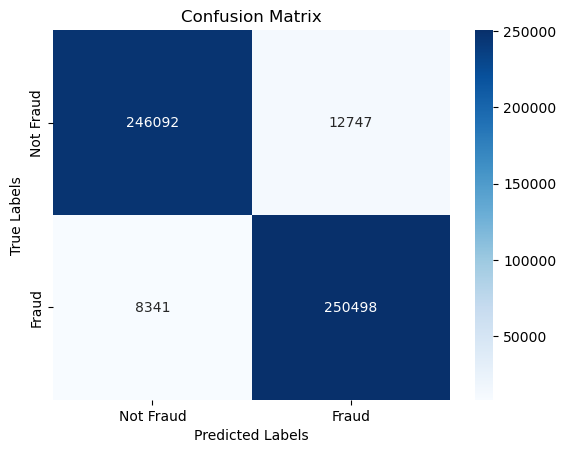

Cross-validated metrics:
AUC: 0.9880 ± 0.0017
Accuracy: 0.9593 ± 0.0025
Precision: 0.9516 ± 0.0060
Recall: 0.9678 ± 0.0072
F1 Score: 0.9596 ± 0.0025


In [39]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import optuna
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('processed_data.csv')

# Ensure TIMESTAMP is in datetime format
if not pd.api.types.is_datetime64_any_dtype(data['TIMESTAMP']):
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

# Creating interaction features and temporal features
data['TX_AMOUNT_INIT_BALANCE_RATIO'] = data['TX_AMOUNT'] / data['INIT_BALANCE']
data['HOUR'] = data['TIMESTAMP'].dt.hour
data['DAY_OF_WEEK'] = data['TIMESTAMP'].dt.dayofweek
data['MONTH'] = data['TIMESTAMP'].dt.month

# Behavioral patterns
data['TX_AMOUNT_MOVING_AVG'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).mean()
data['TX_AMOUNT_MOVING_STD'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).std()
data['NUM_TX_24H'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].rolling(window=24, min_periods=1).count().reset_index(0, drop=True)

# Graph-based features
G = nx.from_pandas_edgelist(data, 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', ['TX_AMOUNT'])
pagerank_dict = nx.pagerank(G)
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=500)
data['PAGERANK'] = data['SENDER_ACCOUNT_ID'].map(pagerank_dict).fillna(0)
data['EIGENVECTOR_CENTRALITY'] = data['SENDER_ACCOUNT_ID'].map(eigenvector_dict).fillna(0)

# Prepare data for GNN model
features = ['TX_AMOUNT_INIT_BALANCE_RATIO', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'TX_AMOUNT_MOVING_AVG', 'TX_AMOUNT_MOVING_STD', 'NUM_TX_24H', 'PAGERANK', 'EIGENVECTOR_CENTRALITY']
data_x = data[features].fillna(0).values
data_y = data['IS_FRAUD'].values

# Normalize features
scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)

# Apply SMOTE
smote = SMOTE(random_state=42)
data_x, data_y = smote.fit_resample(data_x, data_y)

# Convert to torch tensors
data_x = torch.tensor(data_x, dtype=torch.float)
data_y = torch.tensor(data_y, dtype=torch.float).unsqueeze(1)

# Create edge_index for PyG data object
unique_nodes = pd.Index(data['SENDER_ACCOUNT_ID'].append(data['RECEIVER_ACCOUNT_ID']).unique())
node_mapping = {node: i for i, node in enumerate(unique_nodes)}
data['SENDER_ID_REINDEX'] = data['SENDER_ACCOUNT_ID'].map(node_mapping)
data['RECEIVER_ID_REINDEX'] = data['RECEIVER_ACCOUNT_ID'].map(node_mapping)
edge_index = torch.tensor([data['SENDER_ID_REINDEX'].values, data['RECEIVER_ID_REINDEX'].values], dtype=torch.long)

# Set up device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GNNModel(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout_rate, activation_function):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, num_classes)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

        if activation_function == 'relu':
            self.activation = torch.nn.ReLU()
        elif activation_function == 'leaky_relu':
            self.activation = torch.nn.LeakyReLU()
        elif activation_function == 'elu':
            self.activation = torch.nn.ELU()
        elif activation_function == 'selu':
            self.activation = torch.nn.SELU()
        else:
            raise ValueError("Invalid activation function")

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def cross_val_score_gnn(model_class, data_x, data_y, edge_index, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    val_aucs, val_accuracies, val_precisions, val_recalls, val_f1s = [], [], [], [], []
    all_preds, all_labels = [], []

    for train_idx, val_idx in skf.split(data_x.numpy(), data_y.numpy()):
        train_data = Data(x=data_x[train_idx], edge_index=edge_index, y=data_y[train_idx])
        val_data = Data(x=data_x[val_idx], edge_index=edge_index, y=data_y[val_idx])

        model = model_class(num_features=data_x.shape[1], hidden_dim=128, num_classes=1, 
                            dropout_rate=0.12123553484148883, activation_function='elu').to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.008383895739955304, weight_decay=1e-4)
        criterion = torch.nn.BCEWithLogitsLoss()

        train_loader = DataLoader([train_data], batch_size=64, shuffle=True)
        val_loader = DataLoader([val_data], batch_size=64, shuffle=False)

        best_val_loss = float('inf')
        patience_counter = 0
        early_stopping_patience = 10

        model.train()
        for epoch in range(100):
            for batch in train_loader:
                batch = batch.to(device)
                optimizer.zero_grad()
                out = model(batch)
                out = out.view(-1)
                loss = criterion(out, batch.y.view(-1))
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                val_out = model(val_data.to(device))
                val_out = val_out.view(-1)
                val_loss = criterion(val_out, val_data.y.view(-1))

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= early_stopping_patience:
                    print(f'Early stopping at epoch {epoch+1}')
                    break
            model.train()

        model.eval()
        with torch.no_grad():
            val_out = model(val_data.to(device))
            val_out = val_out.view(-1)
            val_preds = torch.sigmoid(val_out).round().cpu().numpy()
            val_labels = val_data.y.cpu().numpy()

            val_auc = roc_auc_score(val_labels, val_out.cpu().numpy())
            val_accuracy = accuracy_score(val_labels, val_preds)
            val_precision = precision_score(val_labels, val_preds, zero_division=0)
            val_recall = recall_score(val_labels, val_preds)
            val_f1 = f1_score(val_labels, val_preds)

            val_aucs.append(val_auc)
            val_accuracies.append(val_accuracy)
            val_precisions.append(val_precision)
            val_recalls.append(val_recall)
            val_f1s.append(val_f1)
            
            all_preds.extend(val_preds)
            all_labels.extend(val_labels)

    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        'AUC': (np.mean(val_aucs), np.std(val_aucs)),
        'Accuracy': (np.mean(val_accuracies), np.std(val_accuracies)),
        'Precision': (np.mean(val_precisions), np.std(val_precisions)),
        'Recall': (np.mean(val_recalls), np.std(val_recalls)),
        'F1 Score': (np.mean(val_f1s), np.std(val_f1s))
    }

metrics = cross_val_score_gnn(GNNModel, data_x, data_y, edge_index)
print(f"Cross-validated metrics:")
for metric, values in metrics.items():
    mean, std = values
    print(f'{metric}: {mean:.4f} ± {std:.4f}')

Feature: TX_AMOUNT_INIT_BALANCE_RATIO, Importance: 0.0012
Feature: HOUR, Importance: 0.0029
Feature: DAY_OF_WEEK, Importance: 0.0023
Feature: MONTH, Importance: 0.0033
Feature: TX_AMOUNT_MOVING_AVG, Importance: 0.0328
Feature: TX_AMOUNT_MOVING_STD, Importance: 0.4268
Feature: NUM_TX_24H, Importance: 0.0262
Feature: PAGERANK, Importance: 0.0005
Feature: EIGENVECTOR_CENTRALITY, Importance: 0.0015


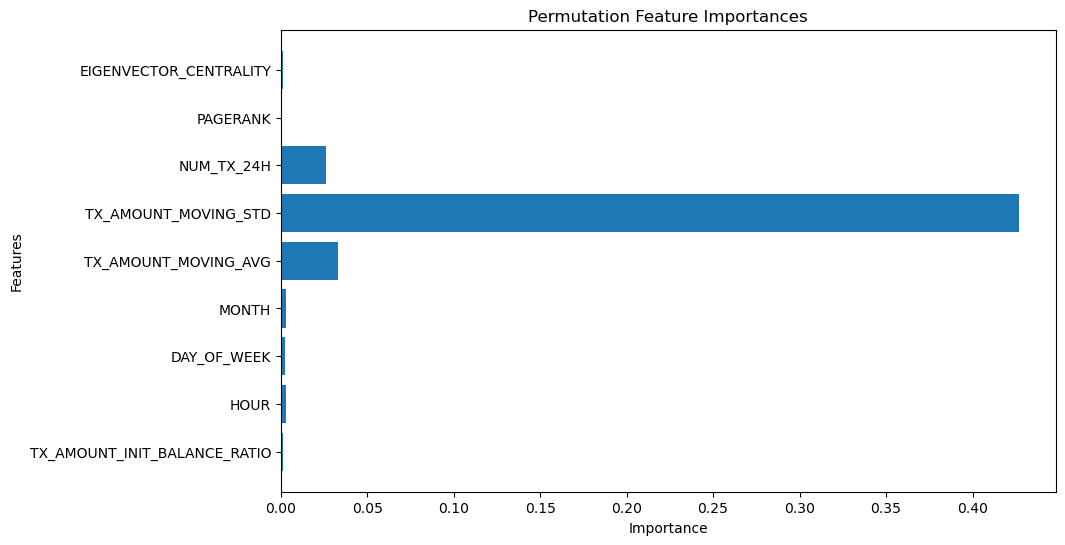

In [51]:
def permutation_feature_importance(model, data, features, metric=roc_auc_score, n_repeats=5):
    baseline_score = metric(data.y.cpu().numpy(), model(data).cpu().detach().numpy().reshape(-1))
    feature_importances = []

    for feature_idx in range(len(features)):
        scores = []
        for _ in range(n_repeats):
            permuted_data = data.clone()
            permuted_data.x[:, feature_idx] = permuted_data.x[:, feature_idx][torch.randperm(permuted_data.x.size(0))]
            permuted_score = metric(data.y.cpu().numpy(), model(permuted_data).cpu().detach().numpy().reshape(-1))
            scores.append(baseline_score - permuted_score)
        feature_importances.append(np.mean(scores))
    
    return feature_importances

eature_importances = permutation_feature_importance(model, test_data, features)

# Display the feature importances
for feature, importance in zip(features, feature_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")

# Bar plot for feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Permutation Feature Importances')
plt.show()

In [42]:
import torch
import pickle

# Save the trained model
torch.save(model.state_dict(), 'gnn_model.pth')

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the node mapping
with open('node_mapping.pkl', 'wb') as f:
    pickle.dump(node_mapping, f)

# Save the dataset, edge_index, and other variables if needed
data_dict = {
    'data_x': data_x,
    'data_y': data_y,
    'edge_index': edge_index,
    'features': features,
    'target': 'IS_FRAUD'
}

with open('data_dict.pkl', 'wb') as f:
    pickle.dump(data_dict, f)

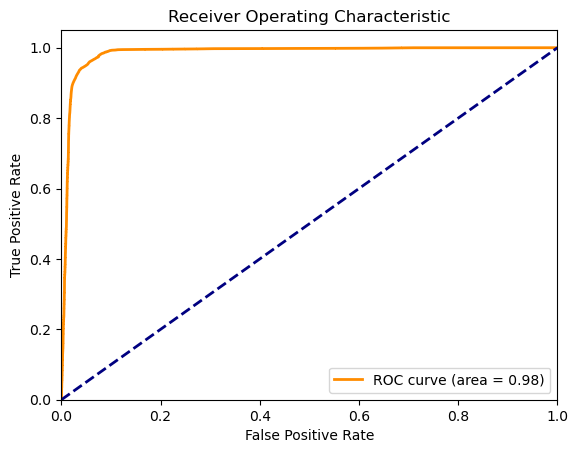

In [46]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

# Load saved components
model = GNNModel(num_features=len(features), hidden_dim=128, num_classes=1, 
                 dropout_rate=0.12123553484148883, activation_function='elu')
model.load_state_dict(torch.load('gnn_model.pth'))
model.to(device)
model.eval()

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('node_mapping.pkl', 'rb') as f:
    node_mapping = pickle.load(f)

with open('data_dict.pkl', 'rb') as f:
    data_dict = pickle.load(f)

data_x = data_dict['data_x']
data_y = data_dict['data_y']
edge_index = data_dict['edge_index']
features = data_dict['features']

# Prepare data for prediction
test_data = Data(x=data_x, edge_index=edge_index, y=data_y)

# Example: Making predictions with the loaded model
with torch.no_grad():
    out_test = model(test_data.to(device))
    preds_test = torch.sigmoid(out_test).round().cpu().numpy()
    y_test = test_data.y.cpu().numpy()
    out_test_np = out_test.cpu().numpy()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, out_test_np)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, out_test_np))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

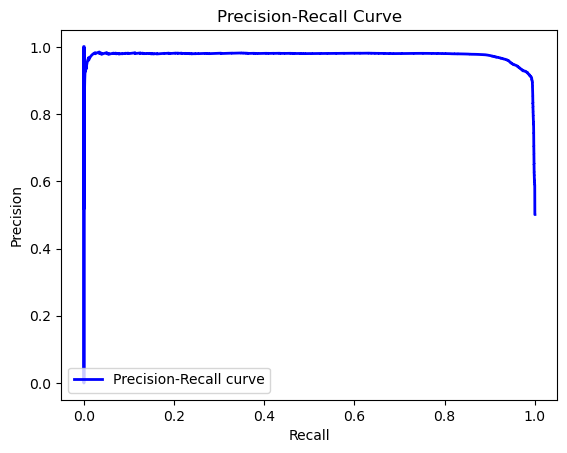

In [47]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, out_test_np)
plt.figure()
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader, Data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('processed_data.csv')

# Ensure TIMESTAMP is in datetime format
if not pd.api.types.is_datetime64_any_dtype(data['TIMESTAMP']):
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])

# Creating interaction features and temporal features
data['TX_AMOUNT_INIT_BALANCE_RATIO'] = data['TX_AMOUNT'] / data['INIT_BALANCE']
data['HOUR'] = data['TIMESTAMP'].dt.hour
data['DAY_OF_WEEK'] = data['TIMESTAMP'].dt.dayofweek
data['MONTH'] = data['TIMESTAMP'].dt.month

# Behavioral patterns
data['TX_AMOUNT_MOVING_AVG'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).mean()
data['TX_AMOUNT_MOVING_STD'] = data['TX_AMOUNT'].rolling(window=24, min_periods=1).std()
data['NUM_TX_24H'] = data.groupby('SENDER_ACCOUNT_ID')['TX_AMOUNT'].rolling(window=24, min_periods=1).count().reset_index(0, drop=True)

# Graph-based features
G = nx.from_pandas_edgelist(data, 'SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID', ['TX_AMOUNT'])
pagerank_dict = nx.pagerank(G)
eigenvector_dict = nx.eigenvector_centrality(G, max_iter=500)
data['PAGERANK'] = data['SENDER_ACCOUNT_ID'].map(pagerank_dict).fillna(0)
data['EIGENVECTOR_CENTRALITY'] = data['SENDER_ACCOUNT_ID'].map(eigenvector_dict).fillna(0)

# Prepare data for GNN model
features = ['TX_AMOUNT_INIT_BALANCE_RATIO', 'HOUR', 'DAY_OF_WEEK', 'MONTH', 'TX_AMOUNT_MOVING_AVG', 'TX_AMOUNT_MOVING_STD', 'NUM_TX_24H', 'PAGERANK', 'EIGENVECTOR_CENTRALITY']
data_x = data[features].fillna(0).values
data_y = data['IS_FRAUD'].values

# Normalize features
scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)

# Visualize original data
pca = PCA(n_components=2)
data_x_pca = pca.fit_transform(data_x)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(data_x_pca[data_y == 0, 0], data_x_pca[data_y == 0, 1], label='Not Fraud', alpha=0.5)
plt.scatter(data_x_pca[data_y == 1, 0], data_x_pca[data_y == 1, 1], label='Fraud', alpha=0.5)
plt.title('Original data')
plt.legend()

# Apply SMOTE
smote = SMOTE(random_state=42)
data_x, data_y = smote.fit_resample(data_x, data_y)

# Visualize SMOTE data
data_x_resampled_pca = pca.transform(data_x)
plt.subplot(1, 2, 2)
plt.scatter(data_x_resampled_pca[data_y == 0, 0], data_x_resampled_pca[data_y == 0, 1], label='Not Fraud', alpha=0.5)
plt.scatter(data_x_resampled_pca[data_y == 1, 0], data_x_resampled_pca[data_y == 1, 1], label='Fraud', alpha=0.5)
plt.title('SMOTE')
plt.legend()
plt.show()

/Users/analucia/opt/anaconda3/envs/AI-Studio/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SyntaxError: invalid syntax (_metadata_requests.py, line 1512)